# Post-Processed Fair Predictors: Statistical properties of estimators (simulation study)

This notebook accompanies the following paper:

Alan Mishler, Edward H. Kennedy, and Alexandra Chouldechova. **Fairness in Risk Assessment Instruments: Post-Processing to Achieve Counterfactual Equalized Odds**. 2021.  In Proceedings of the 2021 ACM Conference on Fairness, Accountability, and Transparency (FAccT '21). Association for Computing Machinery, New York, NY, USA, 386–400. https://doi.org/10.1145/3442188.3445902

It conducts a comprehensive simulation study to validate the statistical and fairness properties of post-processed predictors under various settings. The methods simulate data, apply fairness-aware optimization, and evaluate performance using both doubly robust and plugin estimators. All results are visualized and interpreted to demonstrate how estimation error and fairness constraints affect predictive accuracy.

---

### Pre-Data vs. Post-Data
- **Pre-data**: The original dataset used to train a risk assessment instrument $R$ that is instantiated as a predictive model for the observed outcome $Y$. (Note that in the paper the risk assessment instrument is referred to as $S$, but $R$ is used throughout the code.)
- **Post-data**: A simulated dataset that reflects the influence of the risk assessment instrument $R$ on decisions $D$, after $R$ has been trained.

---

### Tasks in the Simulation Study
- **Task 1**: Simulate error due to estimating $\widehat{\theta}$, the weights that index the post-processed predictor, while treating performance metrics as known. No confidence intervals are needed since metric evaluation is done on a simulated dataset where the potential outcomes $Y^0$ are known, so metric estimation is highly accurate.
- **Task 2**: Estimate performance metrics and calculate confidence intervals to evaluate statistical properties (e.g. coverage) of the performance estimators.
- **Task 3**: Visualize the tradeoff between fairness and accuracy as the constraints on the counterfactual False Positive Rate gap ($\epsilon^+$) and the counterfactual False Negative Rate gap ($\epsilon^-$) vary.

---

### Simulation Settings
- **Setting 1**: Equal fairness constraints ($\epsilon^+ = \epsilon^- = 0.05$\)
- **Setting 2**: Asymmetric fairness constraints (e.g., $\epsilon^+ = 0.10, \epsilon^- = 0.20$)
- **Setting 3**: No fairness constraints ($\epsilon^+ = \epsilon^- = 1$)

Each setting is evaluated with increasing sample size $n$ to assess convergence behavior.

---

### Nuisance Parameter Noise and Root-n Convergence
- Given sensitive feature $A$, other covariates $X$, treatment/decision $D$, and input predictor $R$, the nuisance parameters are the propensity score function $\pi(A, X, R)$ and the outcome regression $\mu_0(A, X, R, D)$. (See the appendix of the paper for a table of notation.)
    - $\pi(A, X, R) := \mathbb{P}(D = 1 \mid A, X, R)$
    - $\mu_0(A, X, R, D) := \mathbb{E}[Y \mid A, X, R, D = 0]$

To simulate estimation error for these funcctions, we add noise directly to their true values at a rate of $1/n^{0.26}$. This is designed to illustrate the theoretical guarantees in the paper, namely that the doubly robust estimators (but not the plugin estimators) are $\sqrt{n}$-consistent and asymptotically normal.

---

### Scaled Error Plots
- Plots for are scaled by powers of $n$, namely $n^{0.25}, n^{0.50}, n^{0.75}, n^{1}$.
- These once again illustrate help that the doubly robust estimators (but not the plugin estimators) are $\sqrt{n}$-consistent and asymptotically normal

---

### Estimators: Plugin vs Doubly Robust vs "True" estimates
- **Plugin**: Use $\widehat{\mu}_0(A, X, R, D)$ as the outcome to construct estimators
- **Doubly Robust Estimators**: Use $\widehat{\phi}$ as the outcome to construct estimators, where $\widehat{\phi}(A, X, R, D) := \frac{1-D}{1-\pi(A, X, R)}(Y - \mu_0(A, X, R, D) + \mu_0(A, X, R, D)$ are doubly robust pseudo-outcomes, or equivalently uncentered influence function values for $\mathbb{E}[Y^0]$. These estimators utilize both the propensity scores and the outcome regressions to achieve better statistical properties than plugin estimators.
- **\"True\" Estimates**: Use known values of $\mu_0$ from the simulation setup to benchmark estimator performance. The only estimation error here comes from the finite samples, but it's negligible since we use large simulated test sets.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import joblib
import os
import pickle
import random

## Ignore warnings from joblib about workers stopping
import warnings
warnings.filterwarnings("ignore", message=".*A worker stopped while some jobs.*")

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [3]:
from counterfactualEO.functions_estimation import(
    risk_coefs,
    fairness_coefs,
    optimize,
)

from counterfactualEO.functions_evaluation import(
    metrics_post_simple,
    coverage,
    add_reference_values,
)

from counterfactualEO.functions_simulation import (
    add_noise_expit,
    add_noise_logit,
    generate_data_pre,
    generate_data_post,
    generate_data_post_noisy,
    check_data_post,
    simulate_true,
    simulate_task1,
    simulate_task1_metrics_to_df,
    simulate_task2,
    simulate_performance_tradeoff,
)

from counterfactualEO.functions_plotting import (
    transform_metrics,
    plot_noise,
    plot_metrics,
)

In [58]:
## Set aesthetics for plots

mpl.rcdefaults()
sns.reset_defaults()
sns.set_theme(style='ticks', context='notebook')

## Make sure tick marks are visible
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

# Add gridlines explicitly for both axes
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'both'
mpl.rcParams['axes.grid.which'] = 'major'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.color'] = '0.9'
mpl.rcParams['grid.alpha'] = 1.0

In [5]:
%matplotlib inline

In [6]:
# Paths to save data and figures

OUTPATH = '../outputs'
FIGPATH = '../figures'

# Testing data generating parameters

In [7]:
prob_A = 0.3
beta_X = [1, -0.8, 4, 2]
beta_D_pre = [0.2, -1, 1, -1, 1]
beta_D_post = [0.2, -1, 1, -1, 1, 1]
beta_Y0 = [-5, 2, -3, 4, -5]
beta_Y1 = [1, -2, 3, -4, 5]

A = 'A'
X = ['X1', 'X2', 'X3', 'X4']
R = 'R'
D = 'D'
Y = 'Y'

R_preds = [A] + [XX for XX in X]
nuis_preds = [A] + [XX for XX in X] + [R]

In [8]:
## Data used to train input predictor R
dat_pre = generate_data_pre(10_000,prob_A, beta_X, beta_D_pre, beta_Y0, beta_Y1,
                            trunc_pi=0.975)
R_learner = RandomForestClassifier()
R_learner.fit(dat_pre[R_preds], dat_pre['Y'])

## Data used to train fair derived predictor
data = generate_data_post(100_000, prob_A, beta_X, beta_D_post, beta_Y0, beta_Y1,
                          R_learner, trunc_pi=0.975)

## Check data distribution
- Make sure both groups have propensities near 0 for the decision `D`
- Relatedly, make sure the treatment `D = 0` occurs frequently enough
- Make sure cross-tabs of binary values don't have empty cells
- Generally make sure the data generating process doesn't look pathological somehow

Cross-tabs for sensitive feature A, decision D, potential outcome Y0, and observable outcome Y.
---------------
D      0.0    1.0
A                
0.0  27147  42852
1.0  26294   3707
---------------
Y0     0.0    1.0
A                
0.0  35346  34653
1.0   7210  22791
---------------
Y      0.0    1.0
A                
0.0  18859  51140
1.0   7194  22807
---------------

How often Y = Y0: 0.58953 

Properties of input predictor R

-------------------------
Confusion matrix for Y, R
-------------------------
[[0.09451 0.16602]
 [0.10362 0.63585]] 

------------------------------
Classification report for Y, R
------------------------------
              precision    recall  f1-score   support

       Y = 0       0.48      0.36      0.41     26053
       Y = 1       0.79      0.86      0.83     73947

    accuracy                           0.73    100000
   macro avg       0.63      0.61      0.62    100000
weighted avg       0.71      0.73      0.72    100000
 

---------------------

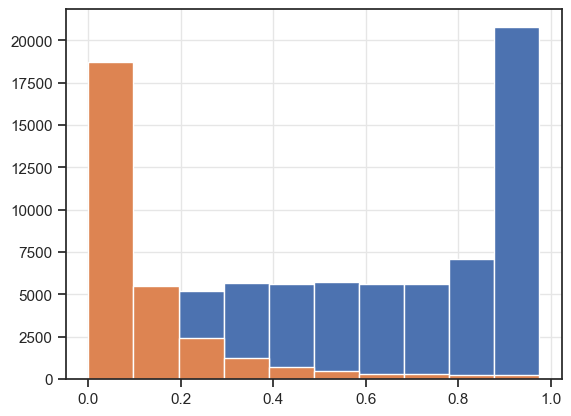

In [9]:
check_data_post(data)

## Check noise added to nuisance parameters

Noise needs to be the right size to meaningfully illustrate convergence. We'll check how noise affects the parameters of the linear program.

We'll compare adding noise directly to $\pi$ and $\mu_0$, on their original scale where they lie in (0, 1), to adding noise on the logit scale and taking the expit to transform them back. The advantage of the latter is that on the logit scale they're unbounded, and when we take the expit to transform them back they still lie in (0, 1). If we add noise on their original scale (referred to as the "expit" scale just for contrast), then we have to clip the values to restore the range to (0, 1).

In [10]:
# Parameters for post-intervention data generation
data_params = {
    'prob_A': prob_A,
    'beta_X': beta_X,
    'beta_D': beta_D_post,
    'beta_Y0': beta_Y0,
    'beta_Y1': beta_Y1,
    'model_R': R_learner,
    'trunc_pi': 0.975,  # Truncation for propensity scores
}

In [11]:
# Get the true values for the LP optimization parameters
epsilon_pos = 0.10
epsilon_neg = 0.10
obj_true = risk_coefs(data, A='A', R='R', outcome='mu0')
pos_true, neg_true = fairness_coefs(data, A='A', R='R', outcome='mu0')
theta = optimize(obj_true, pos_true, neg_true, epsilon_pos, epsilon_neg)

### Adding noise on expit scale to $\pi$ and $\mu0$

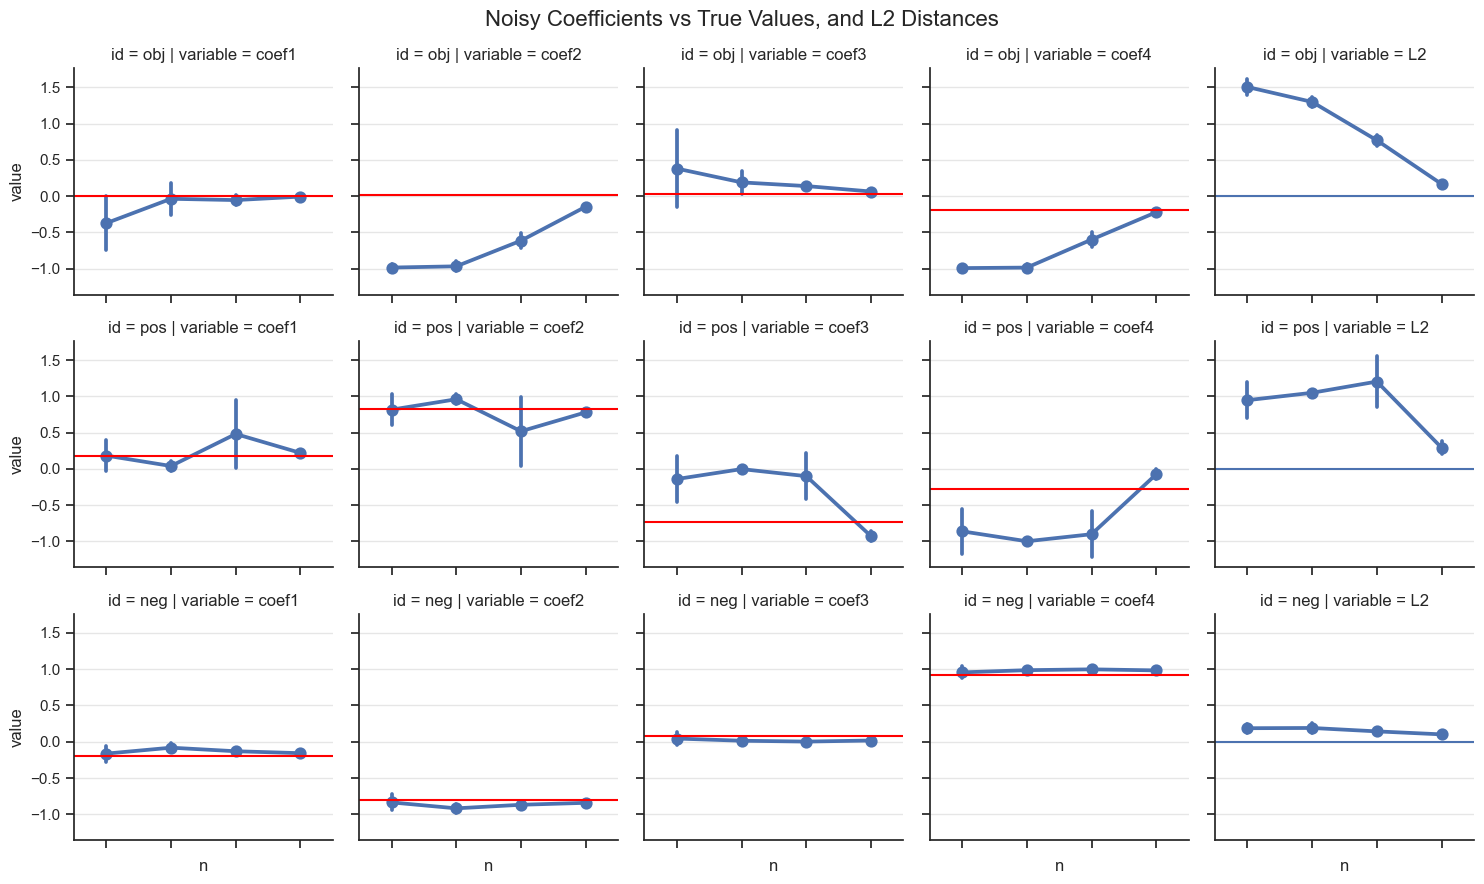

In [12]:
## Setting noise coefficient to 10
n_arr = [200, 1000, 5000, 20000]
mc_reps = 10

noise_coef = 10
res_noise10 = add_noise_expit(n_arr, mc_reps, data_params, obj_true, pos_true, neg_true,
                    noise_coef, trunc_pi=0.975, verbose=False)
plot_noise(res_noise10, obj_true, pos_true, neg_true)

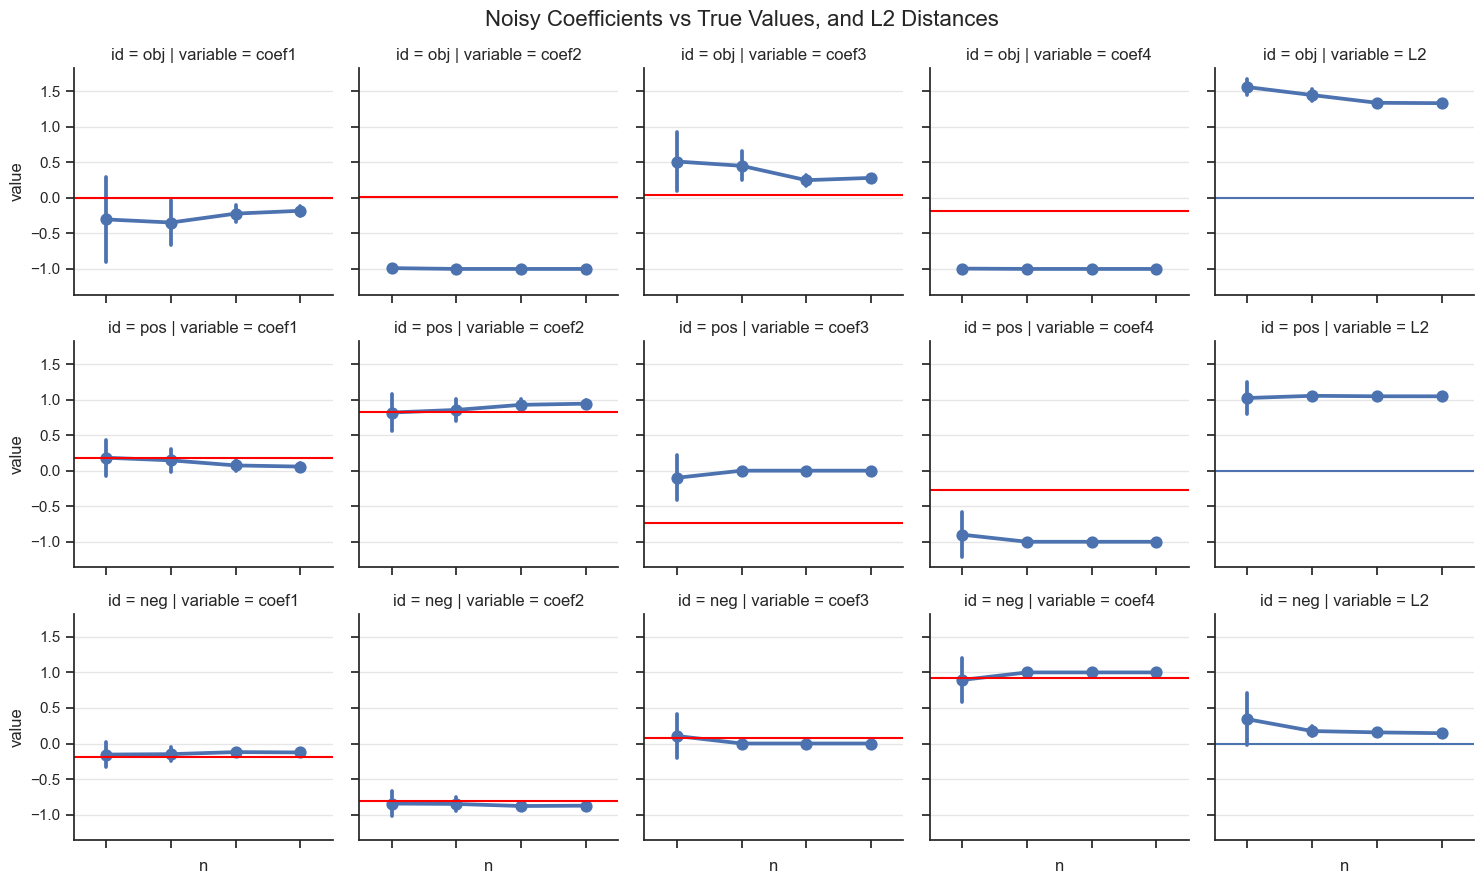

In [13]:
## Setting noise coefficient to 30
noise_coef = 30
res_noise30 = add_noise_expit(n_arr, mc_reps, data_params, obj_true, pos_true, neg_true,
                    noise_coef, trunc_pi=0.975, verbose=False)
plot_noise(res_noise30, obj_true, pos_true, neg_true)

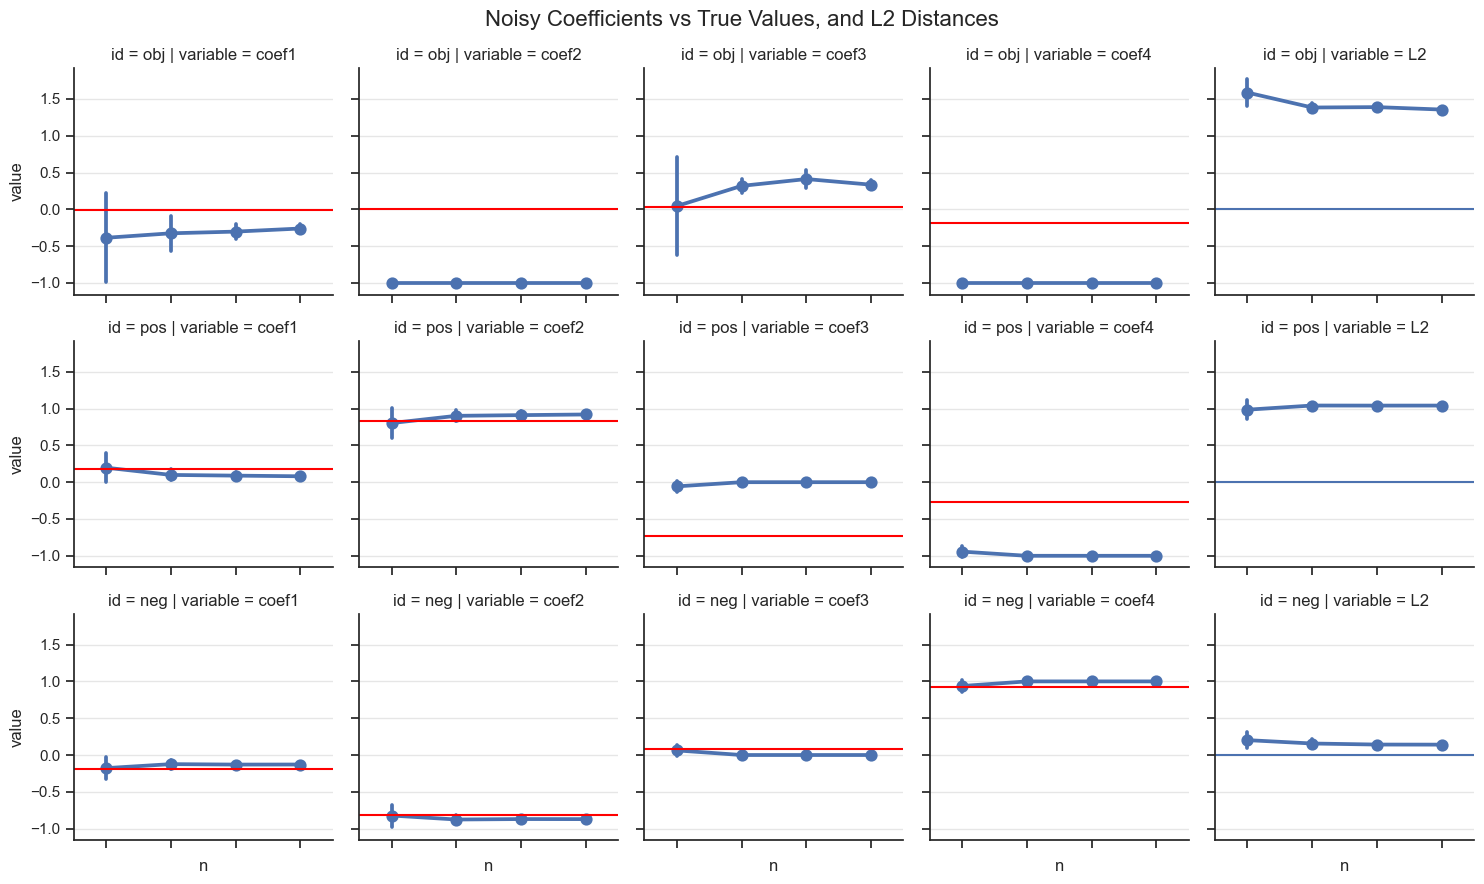

In [14]:
## Setting noise coefficient to 50
## This gives too much noise, with some coefficient vectors landing at the 
## extremes of 1 or -1. 

noise_coef = 50
res_noise50 = add_noise_expit(n_arr, mc_reps, data_params, obj_true, pos_true, neg_true,
                    noise_coef, trunc_pi=0.975, verbose=False)
plot_noise(res_noise50, obj_true, pos_true, neg_true)

### Adding noise on logit scale to $\pi$ and $\mu0$

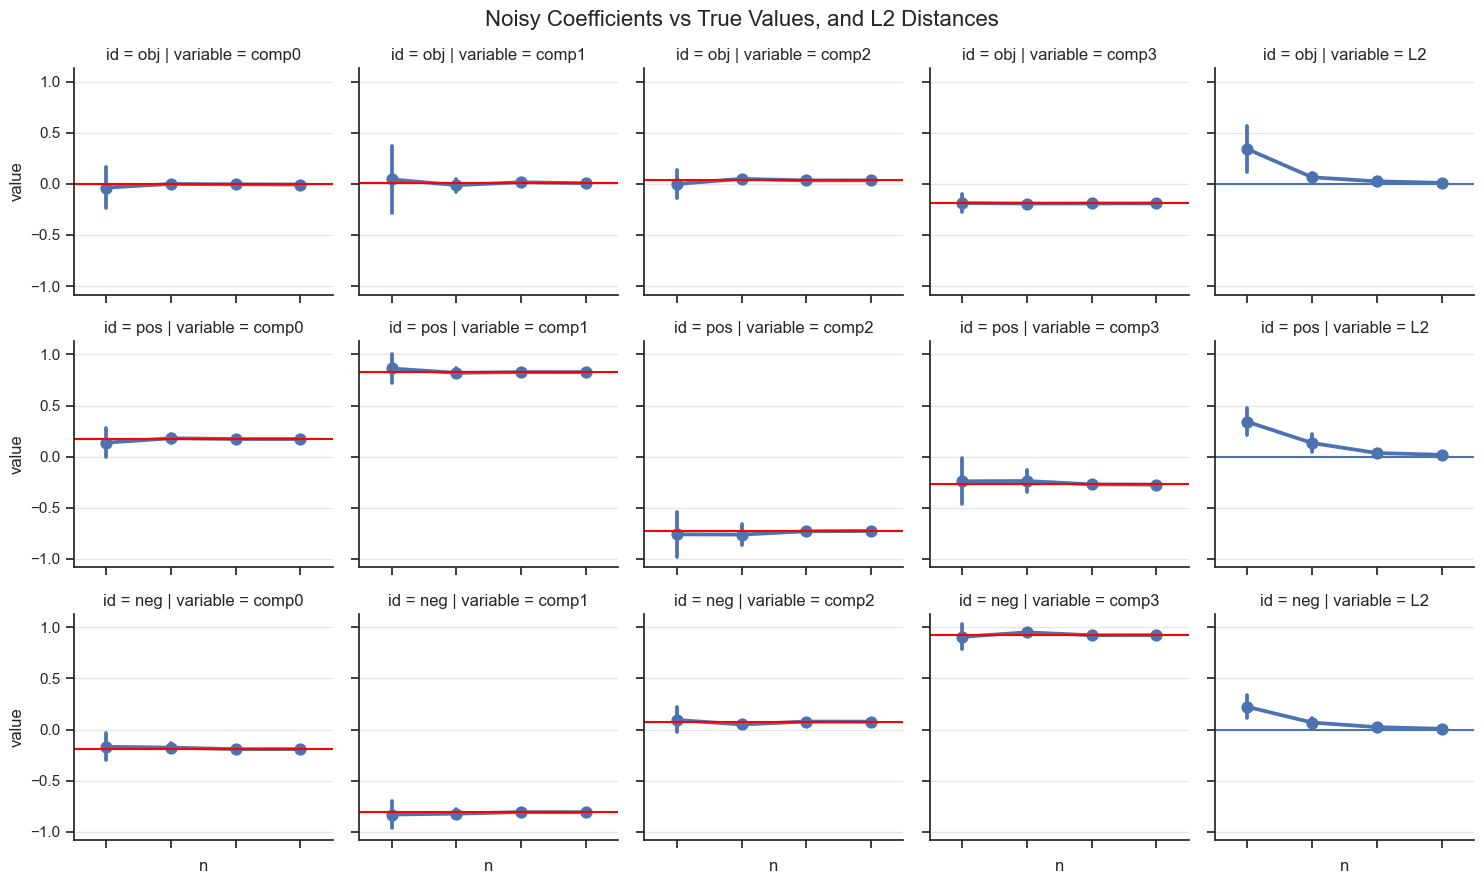

In [15]:
## Noise coefficient of 10
n_arr = [200, 1000, 5000, 20000]
mc_reps = 10

noise_coef = 10
res_noise10_2 = add_noise_logit(n_arr, mc_reps, data_params, obj_true, pos_true,
                                neg_true, noise_coef=noise_coef, verbose=False)
plot_noise(res_noise10_2, obj_true, pos_true, neg_true)

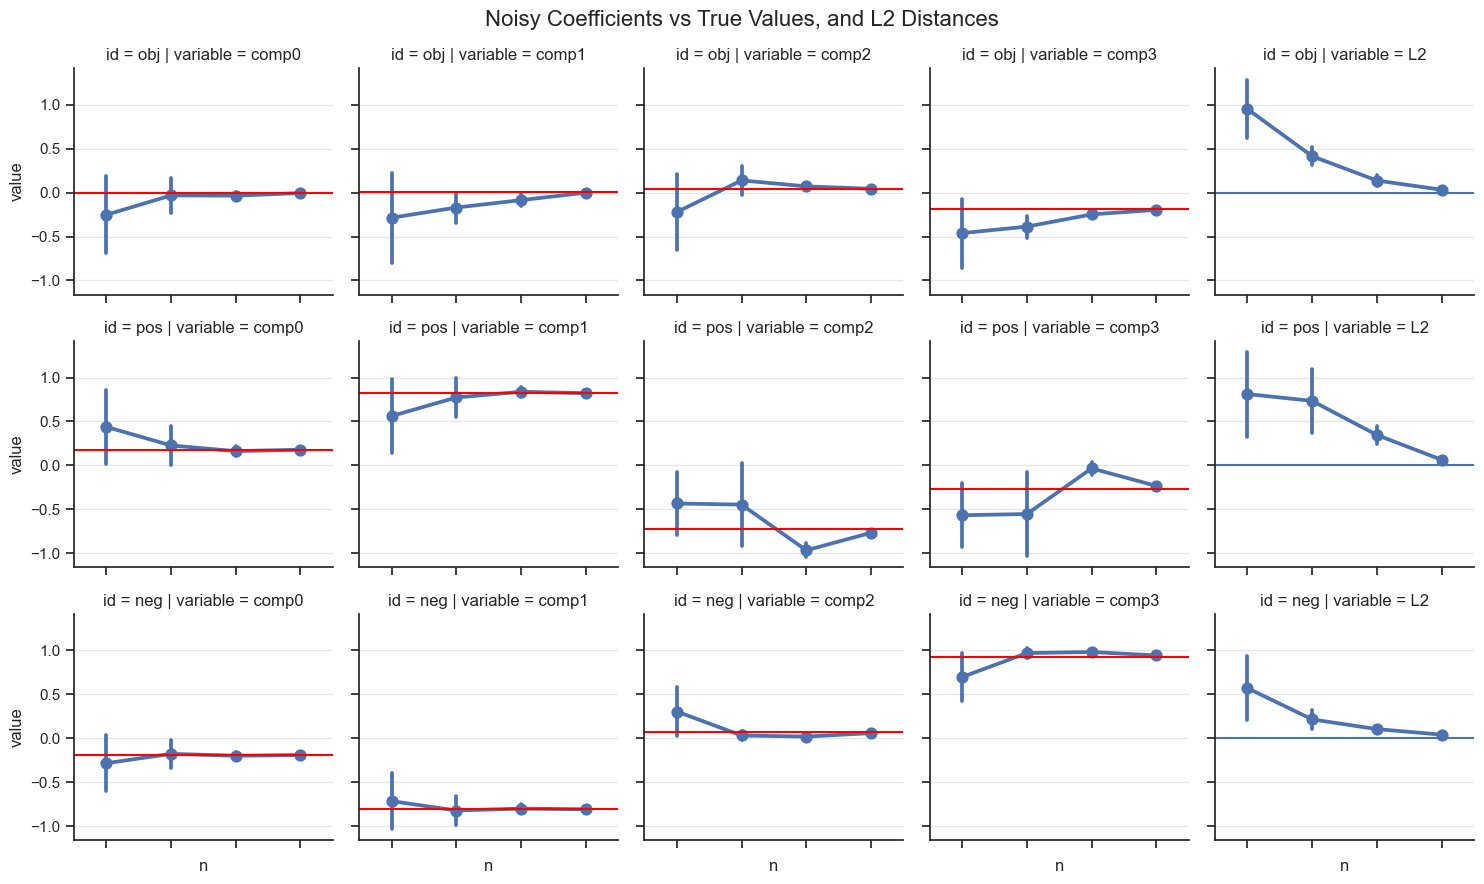

In [16]:
## Noise coefficient of 30
noise_coef = 30
res_noise30_2 = add_noise_logit(n_arr, mc_reps, data_params, obj_true, pos_true,
                                neg_true, noise_coef=noise_coef, verbose=False)
plot_noise(res_noise30_2, obj_true, pos_true, neg_true)

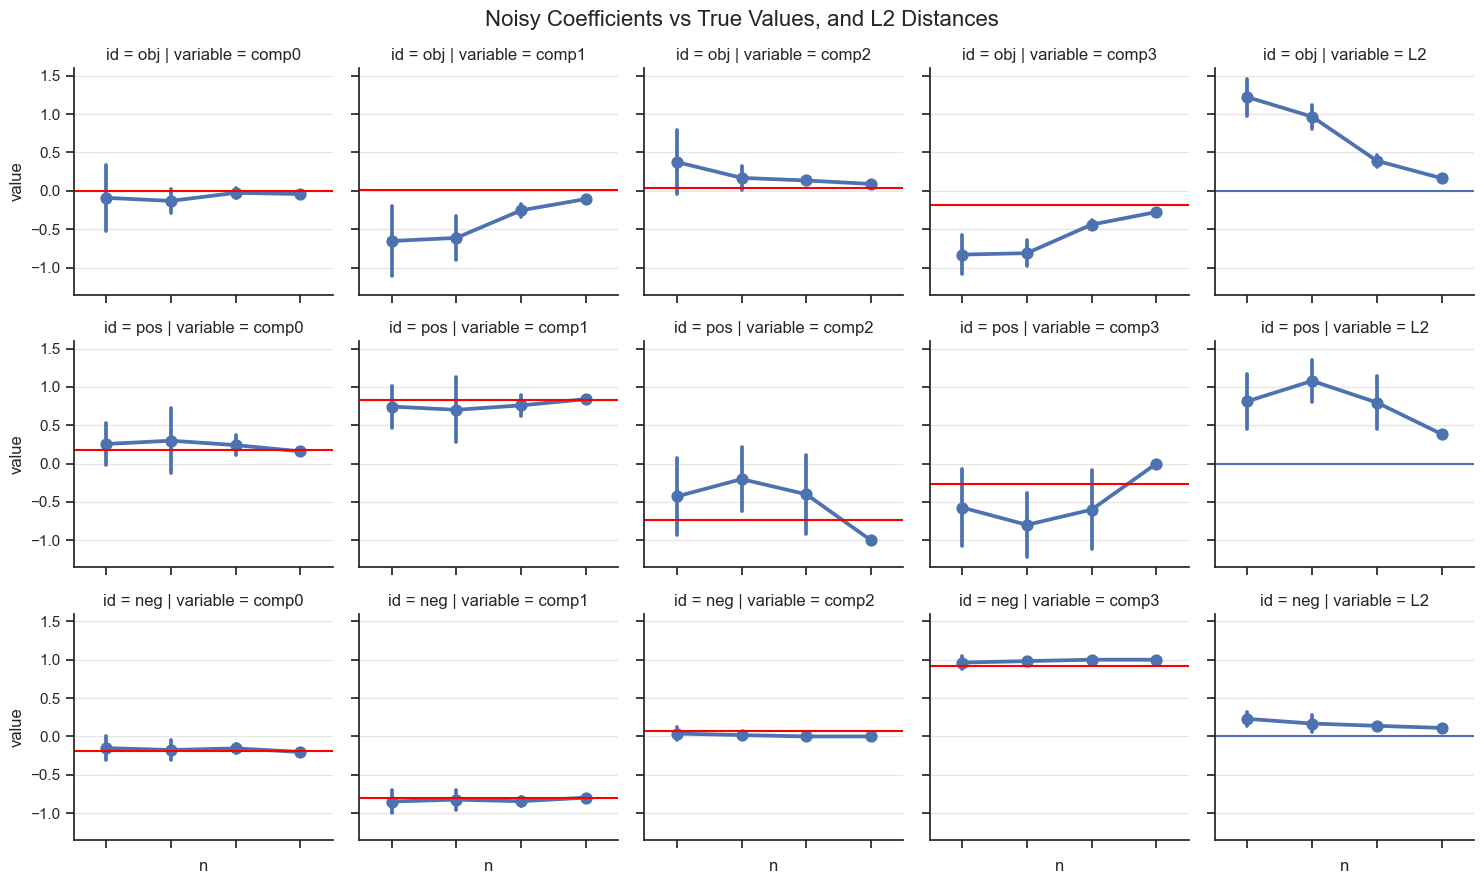

In [17]:
## Noise coefficient of 50
noise_coef = 50
res_noise50_2 = add_noise_logit(n_arr, mc_reps, data_params, obj_true, pos_true,
                                neg_true, noise_coef=noise_coef, verbose=False)
plot_noise(res_noise50_2, obj_true, pos_true, neg_true)

In [18]:
## Checking generate_data_post_noisy
data_test10 = generate_data_post_noisy(10_000, 10, **data_params)
data_test30 = generate_data_post_noisy(10_000, 30, **data_params)

In [19]:
print(pearsonr(data_test10['pi'], data_test10['pihat']))
print(pearsonr(data_test30['pi'], data_test30['pihat']))
print(pearsonr(data_test10['mu0'], data_test10['muhat0']))
print(pearsonr(data_test30['mu0'], data_test30['muhat0']))

PearsonRResult(statistic=0.9302966522500643, pvalue=0.0)
PearsonRResult(statistic=0.6255791716023958, pvalue=0.0)
PearsonRResult(statistic=0.9824407156262995, pvalue=0.0)
PearsonRResult(statistic=0.8798936976868728, pvalue=0.0)


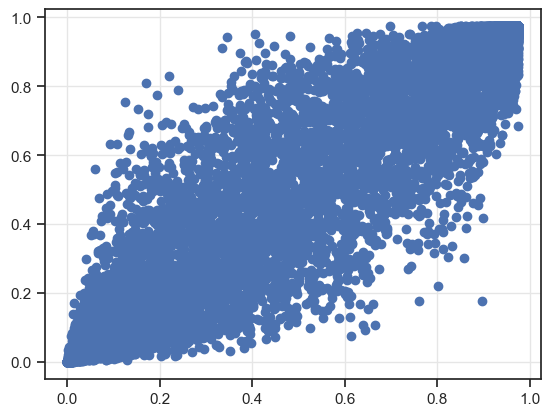

In [20]:
plt.plot(data_test10['pi'], data_test10['pihat'], marker = 'o', linestyle = 'none')

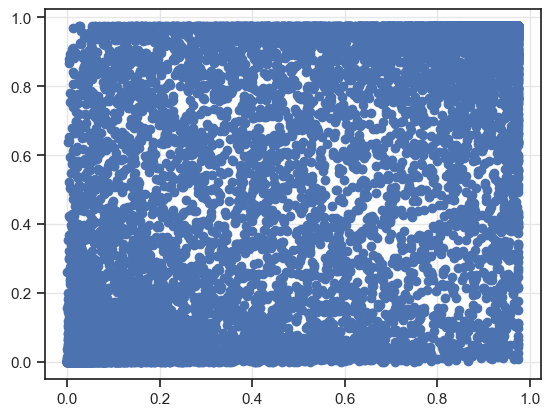

In [21]:
plt.plot(data_test30['pi'], data_test30['pihat'], marker = 'o', linestyle = 'none')

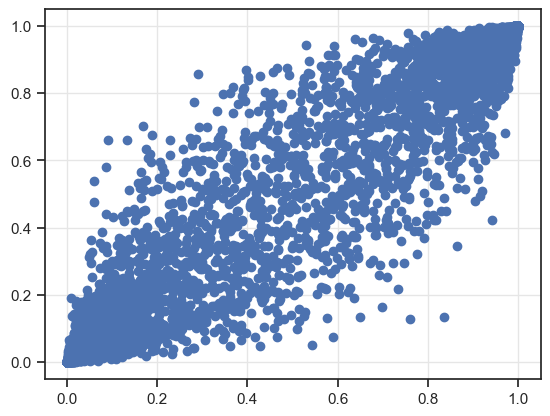

In [22]:
plt.plot(data_test10['mu0'], data_test10['muhat0'], marker = 'o', linestyle = 'none')

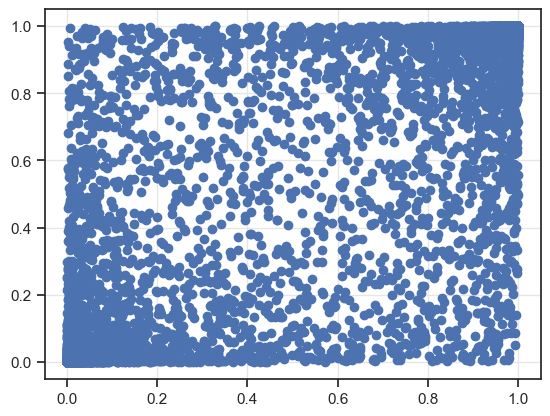

In [23]:
plt.plot(data_test30['mu0'], data_test30['muhat0'], marker = 'o', linestyle = 'none')

# Simulations Setup

## Pre-data generation parameters

In [24]:
prob_A = 0.3
beta_X = [1, -0.8, 4, 2]
beta_D_pre = [0.2, -1, 1, -1, 1]
beta_D_post = [0.2, -1, 1, -1, 1, 1]
beta_Y0 = [-5, 2, -3, 4, -5]
beta_Y1 = [1, -2, 3, -4, 5]

A = 'A'
X = ['X1', 'X2', 'X3', 'X4']
R = 'R'
D = 'D'
Y = 'Y'

R_preds = [A] + [XX for XX in X]

## Train input predictor R

In [25]:
random.seed(42)

dat_pre = generate_data_pre(10_000, prob_A, beta_X, beta_D_pre, beta_Y0, beta_Y1, trunc_pi=0.975)
R_learner = RandomForestClassifier()
R_learner.fit(dat_pre[R_preds], dat_pre['Y'])

joblib.dump(R_learner, os.path.join(OUTPATH, 'R_learner.model'))

['../outputs/R_learner.model']

## Post-data generation parameters

In [26]:
## Read in previously trained predictor R
# with open(os.path.join(OUTPATH, 'R_learner.model'), 'rb') as file_in:
#     R_learner = joblib.load(file_in)

data_params = {
    'prob_A': prob_A,
    'beta_X': beta_X,
    'beta_D': beta_D_post,
    'beta_Y0': beta_Y0,
    'beta_Y1': beta_Y1,
    'model_R': R_learner
}

# Task 1 Simulations
Since we're using simulated data, we know the true values of $\mu_0(X) := \mathbb{E}[Y^0 \mid X]$ and we can create a very large validation dataset, so the estimates of the metrics for the predictors are very precise. Therefore, we don't bother calculating confidence intervals when estimating the metrics.

In other words, the point of task 1 is to evaluate the variability in $\widehat{\theta}$ itself and then estimate the metrics as accurately as possible for the resulting derived predictors. Interest is in estimation error for $\widehat{\theta}$, not in estimation of the metric values.

## Get optimal fair predictors

In [27]:
data_val = generate_data_post(500_000, **data_params)
data_val.to_csv(os.path.join(OUTPATH, 'data_val.csv'), index = False)

### Setting 1: equal epsilon values

In [28]:
## Get optimal predictor
epsilon_pos = 0.05
epsilon_neg = 0.05

pred_best_1 = simulate_true(50_000, data_params, epsilon_pos, epsilon_neg)

## Performance of the optimal fair predictor
pred_best_1['metrics']

,metric,value,ci_lower,ci_upper
0,risk,0.414439,0.410484,0.418405
1,risk_change,0.036919,0.033889,0.039948
2,FPR0,0.937324,0.935404,0.939191
3,FPR1,0.887492,0.883626,0.891246
4,gap_FPR,0.049832,0.045496,0.054166
5,FNR0,0.058916,0.055753,0.062246
6,FNR1,0.010245,0.008328,0.012598
7,gap_FNR,0.048671,0.044267,0.053073
8,pred_change,0.159306,0.156617,0.162032


In [29]:
with open(os.path.join(OUTPATH, 'task1/pred_best_1.pickle'), 'wb') as file_out:
    pickle.dump(pred_best_1, file_out)

### Setting 2: different epsilon values

In [30]:
## Get optimal predictor
epsilon_pos = 0.10
epsilon_neg = 0.20

pred_best_2 = simulate_true(50_000, data_params, epsilon_pos, epsilon_neg)

## Performance of the optimal fair predictor
pred_best_2['metrics']

,metric,value,ci_lower,ci_upper
0,risk,0.401466,0.397559,0.405386
1,risk_change,0.022986,0.021610,0.024363
2,FPR0,0.762304,0.756542,0.767972
3,FPR1,0.663830,0.654413,0.673119
4,gap_FPR,0.098475,0.087556,0.109370
5,FNR0,0.229496,0.220934,0.238289
6,FNR1,0.030547,0.025785,0.036155
7,gap_FNR,0.198950,0.187651,0.210196
8,pred_change,0.066103,0.064850,0.067379


In [31]:
with open(os.path.join(OUTPATH, 'task1/pred_best_2.pickle'), 'wb') as file_out:
    pickle.dump(pred_best_2, file_out)

### Setting 3: no fairness constraints

In [32]:
epsilon_pos = 1.0
epsilon_neg = 1.0

pred_best_3 = simulate_true(50_000, data_params, epsilon_pos, epsilon_neg)

## Performance of the optimal predictor with no fairness constraints
pred_best_3['metrics']

,metric,value,ci_lower,ci_upper
0,risk,3.760400e-01,3.718038e-01,3.802952e-01
1,risk_change,7.134165e-11,4.718670e-12,1.379648e-10
2,FPR0,7.898804e-01,7.837757e-01,7.958576e-01
3,FPR1,2.108939e-01,1.891438e-01,2.344219e-01
4,gap_FPR,5.789865e-01,5.550774e-01,6.019397e-01
5,FNR0,1.984969e-01,1.893207e-01,2.080038e-01
6,FNR1,6.832783e-02,5.673931e-02,8.207726e-02
7,gap_FNR,1.301691e-01,1.123978e-01,1.478572e-01
8,pred_change,6.172625e-09,6.133867e-09,6.211629e-09


In [33]:
with open(os.path.join(OUTPATH, 'task1/pred_best_3.pickle'), 'wb') as file_out:
    pickle.dump(pred_best_3, file_out)

In [34]:
# Combine metrics from all settings for comparison
metrics_best_1 = pred_best_1['metrics']
risk_best1 = metrics_best_1.loc[metrics_best_1['metric'] == 'risk', 'value'].values[0]

metrics_best_2 = pred_best_2['metrics']
risk_best2 = metrics_best_2.loc[metrics_best_2['metric'] == 'risk', 'value'].values[0]

metrics_best_3 = pred_best_3['metrics']   
risk_best3 = metrics_best_3.loc[metrics_best_3['metric'] == 'risk', 'value'].values[0]

metrics_best = pd.concat((metrics_best_1, metrics_best_2, metrics_best_3),
                        keys = ['setting1', 'setting2', 'setting3'])
metrics_best = metrics_best.reset_index().rename(columns = {'level_0': 'setting'}).drop(columns = 'level_1')
with open(os.path.join(OUTPATH, 'task1/metrics_best.pickle'), 'wb') as file_out:
    pickle.dump(metrics_best, file_out)

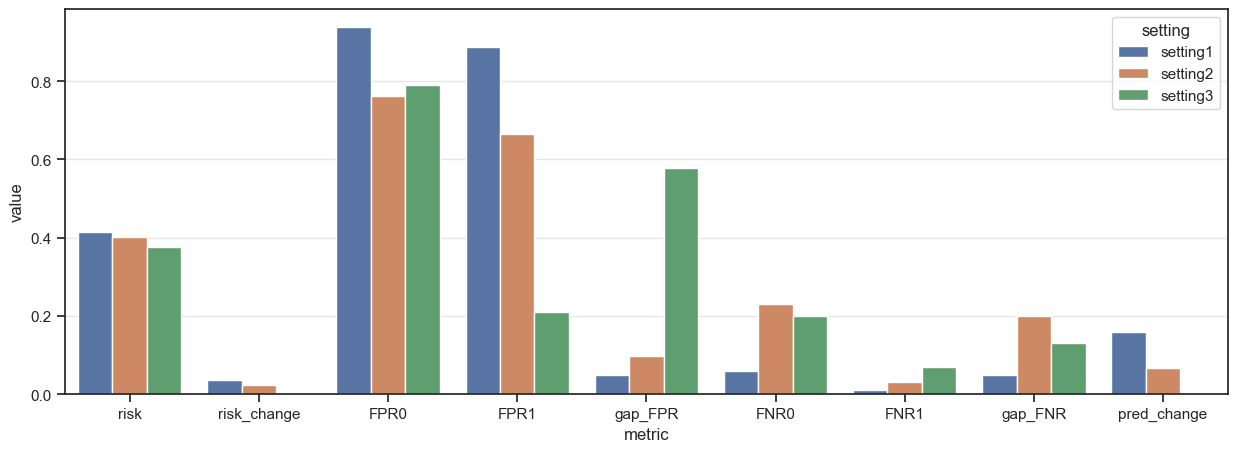

In [35]:
# Plot values for the optimal fair predictors across settings
plt.figure(figsize=(15,5))
g = sns.barplot(x = 'metric', y = 'value', hue = 'setting', data = metrics_best)
g.get_figure().savefig(os.path.join(FIGPATH, 'task1/optimal_predictors.pdf'))

## Get estimated fair predictors: doubly robust

In [36]:
n_arr = [100, 200, 500, 1000, 5000, 20000]
mc_reps = 500
noise_coef = 30

### Setting 1: equal epsilon values 

In [37]:
noise_coef = 30
res1 = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.05,
                   epsilon_neg = 0.05) for nn in n_arr]

Simulating theta-hat for sample size 100 with 500 repetitions...
Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [38]:
metrics1 = simulate_task1_metrics_to_df(res1, n_arr, 'Setting1', data_val, ci=None)
metrics1 = add_reference_values(metrics1, metrics_best_1, new_col='optimal_value')
metrics1.to_csv(os.path.join(OUTPATH, 'task1/metrics1.csv'), index = False)

Evaluating metrics for given values of theta: 100%|██████████| 3000/3000 [02:52<00:00, 17.41it/s]


### Setting 2: different epsilon values

In [39]:
res2 = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.10,
                   epsilon_neg = 0.20) for nn in n_arr]
with open(os.path.join(OUTPATH, 'task1/res2.pickle'), 'wb') as file_out:
    pickle.dump(res2, file_out)

Simulating theta-hat for sample size 100 with 500 repetitions...
Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [40]:
metrics2 = simulate_task1_metrics_to_df(res2, n_arr, 'Setting2', data_val, ci=None)
metrics2 = add_reference_values(metrics2, metrics_best_2, new_col='optimal_value')
metrics2.to_csv(os.path.join(OUTPATH, 'task1/metrics2.csv'), index = False)

Evaluating metrics for given values of theta: 100%|██████████| 3000/3000 [03:03<00:00, 16.36it/s]


### Setting 3: no fairness constraints

In [41]:
res3 = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 1.0,
                   epsilon_neg = 1.0) for nn in n_arr]
with open(os.path.join(OUTPATH, 'task1/res3.pickle'), 'wb') as file_out:
    pickle.dump(res3, file_out)

Simulating theta-hat for sample size 100 with 500 repetitions...
Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [42]:
metrics3 = simulate_task1_metrics_to_df(res3, n_arr, 'Setting3', data_val, ci=None)
metrics3 = add_reference_values(metrics3, metrics_best_3, new_col='optimal_value')
metrics3.to_csv(os.path.join(OUTPATH, 'task1/metrics3.csv'), index = False)

Evaluating metrics for given values of theta: 100%|██████████| 3000/3000 [02:56<00:00, 17.02it/s]


## Plot combined results: doubly robust

### Unscaled

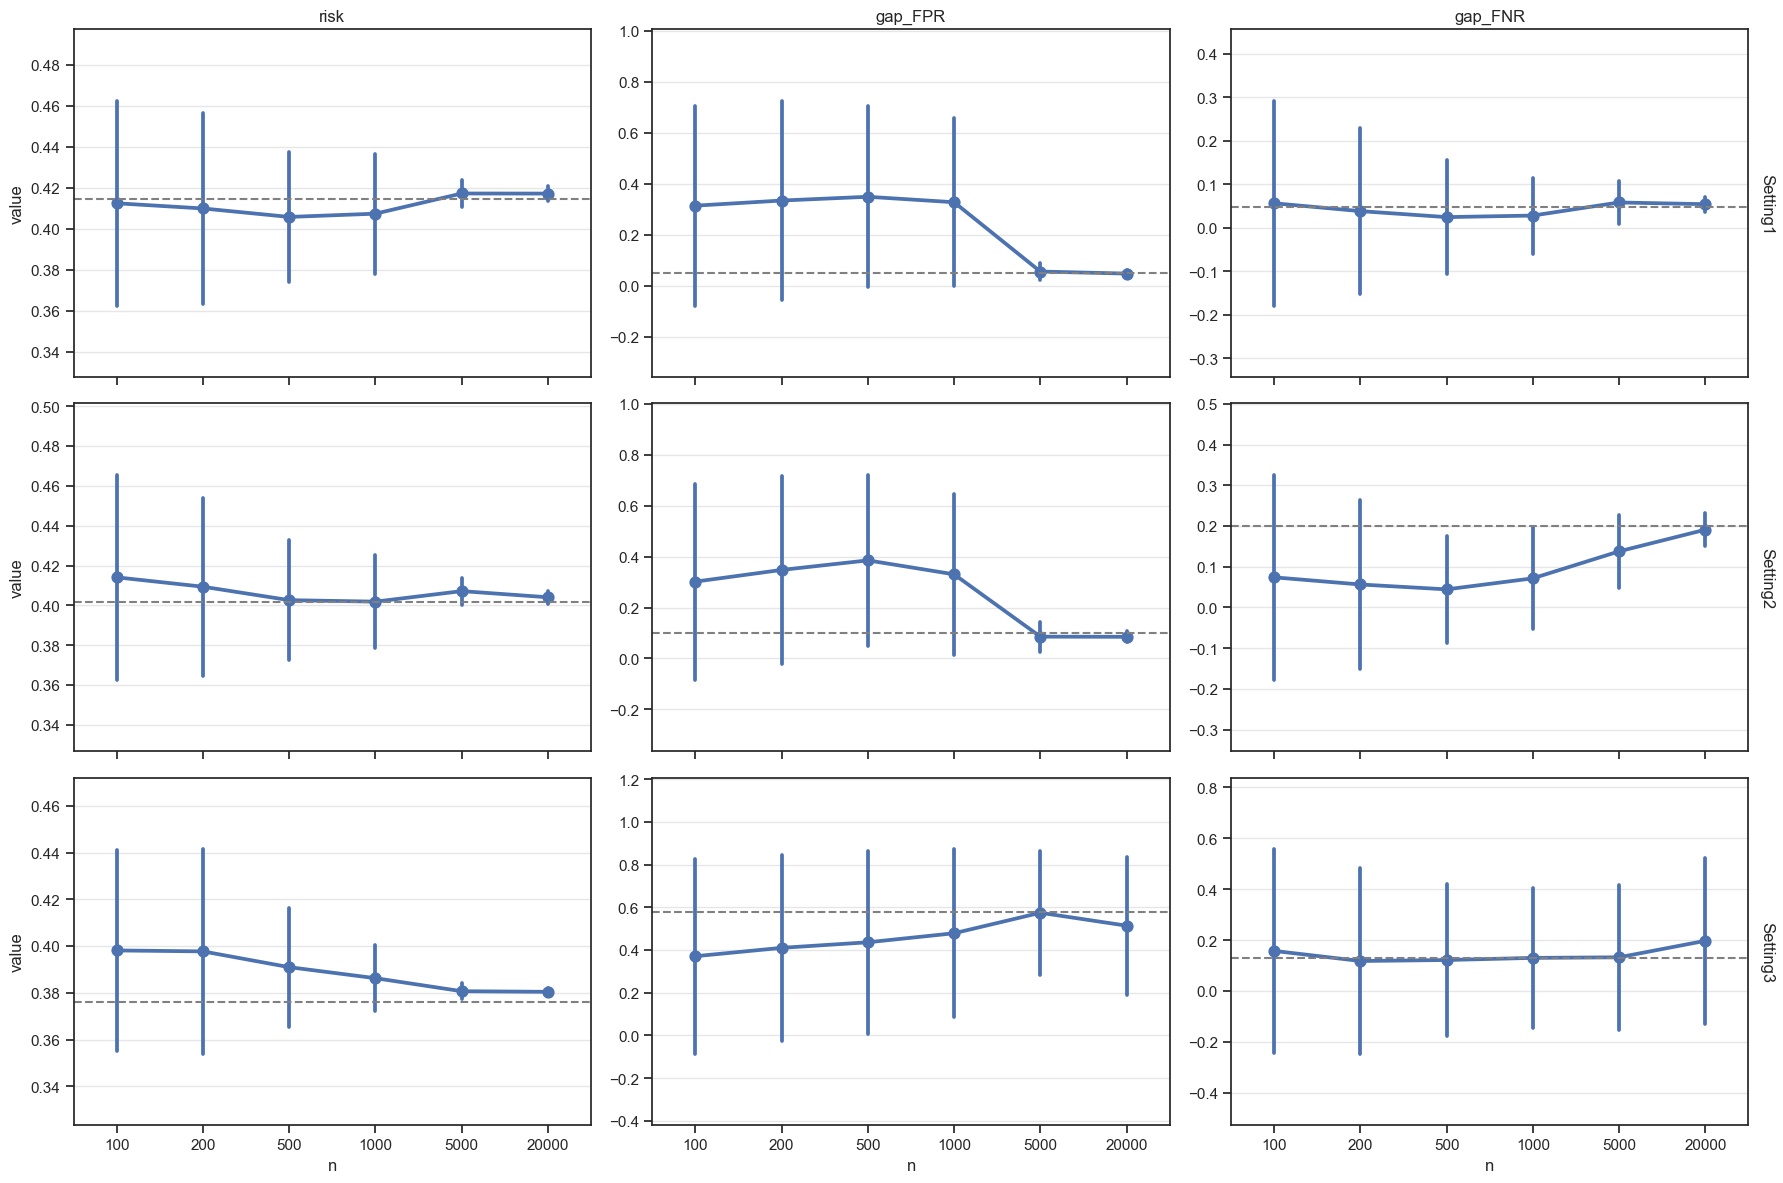

In [ ]:
metrics_comb = pd.concat([metrics1, metrics2, metrics3])
metrics_comb.to_csv(os.path.join(OUTPATH, 'task1/metrics_combined_dr.csv'), index = False)

plot_metrics(metrics_comb, x='n', y='value', row='setting', col='metric',
              row_order=['Setting1', 'Setting2', 'Setting3'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value', centered=False,
                 draw_custom_errorbars=False, max_ticks=6,
                 categorical_x=True, height=4, aspect=1.5)

### Scaled by $n^{0.25}$

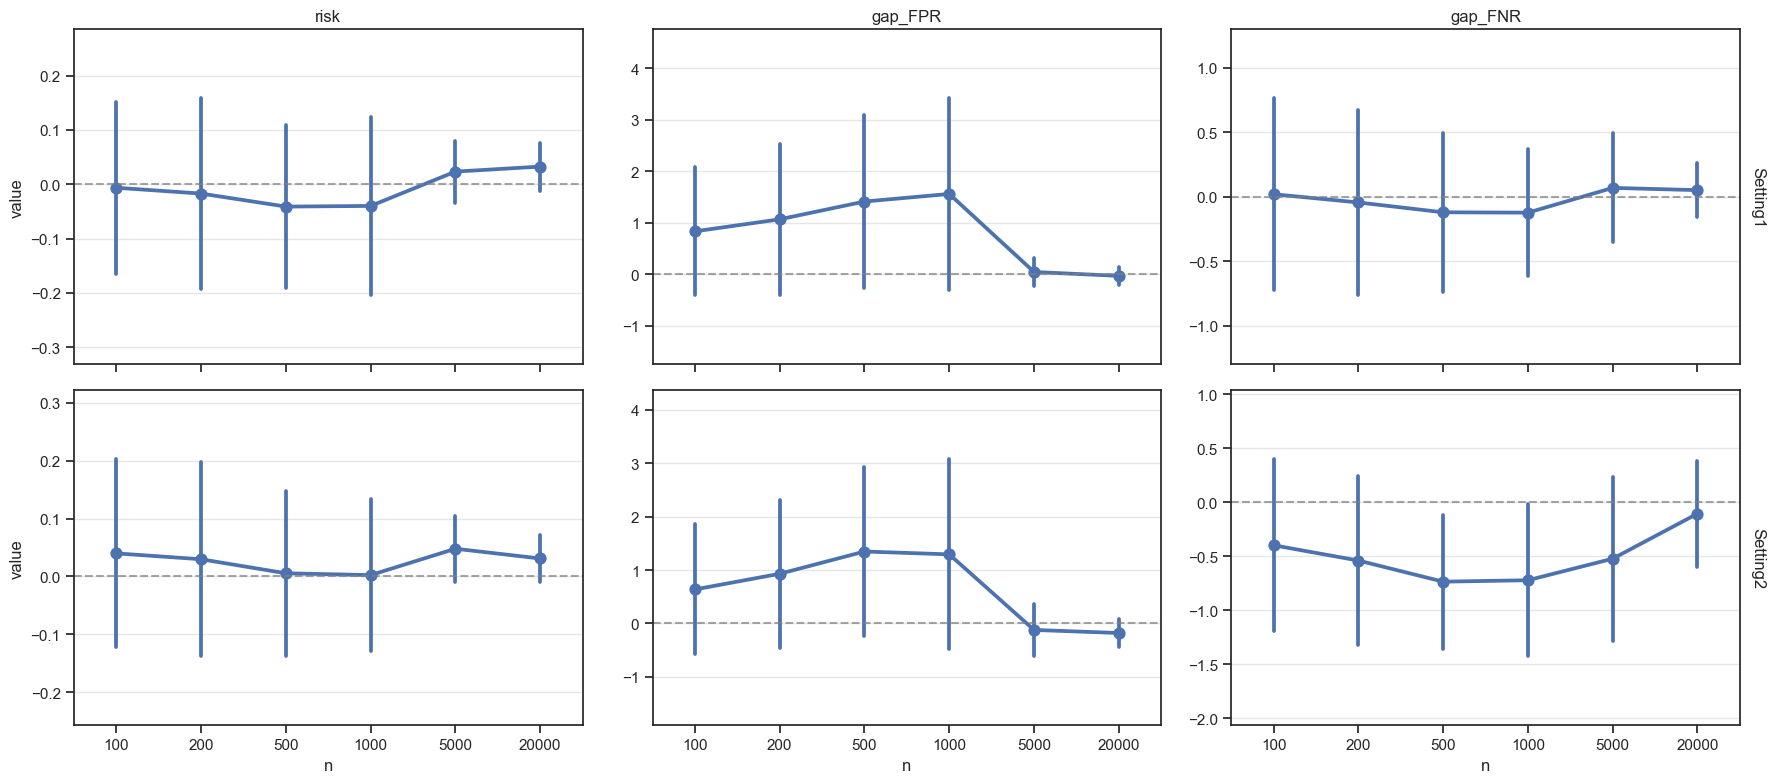

In [44]:
metrics_comb_25 = transform_metrics(metrics_comb, reference_col='optimal_value', scale=0.25)
metrics_comb_25.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_25.csv'), index = False)

plot_metrics(metrics_comb_25, x='n', y='value', row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value', centered=True,
              draw_custom_errorbars=False, max_ticks=6, height=4, aspect=1.5)

### Scaled by $\sqrt{n}$

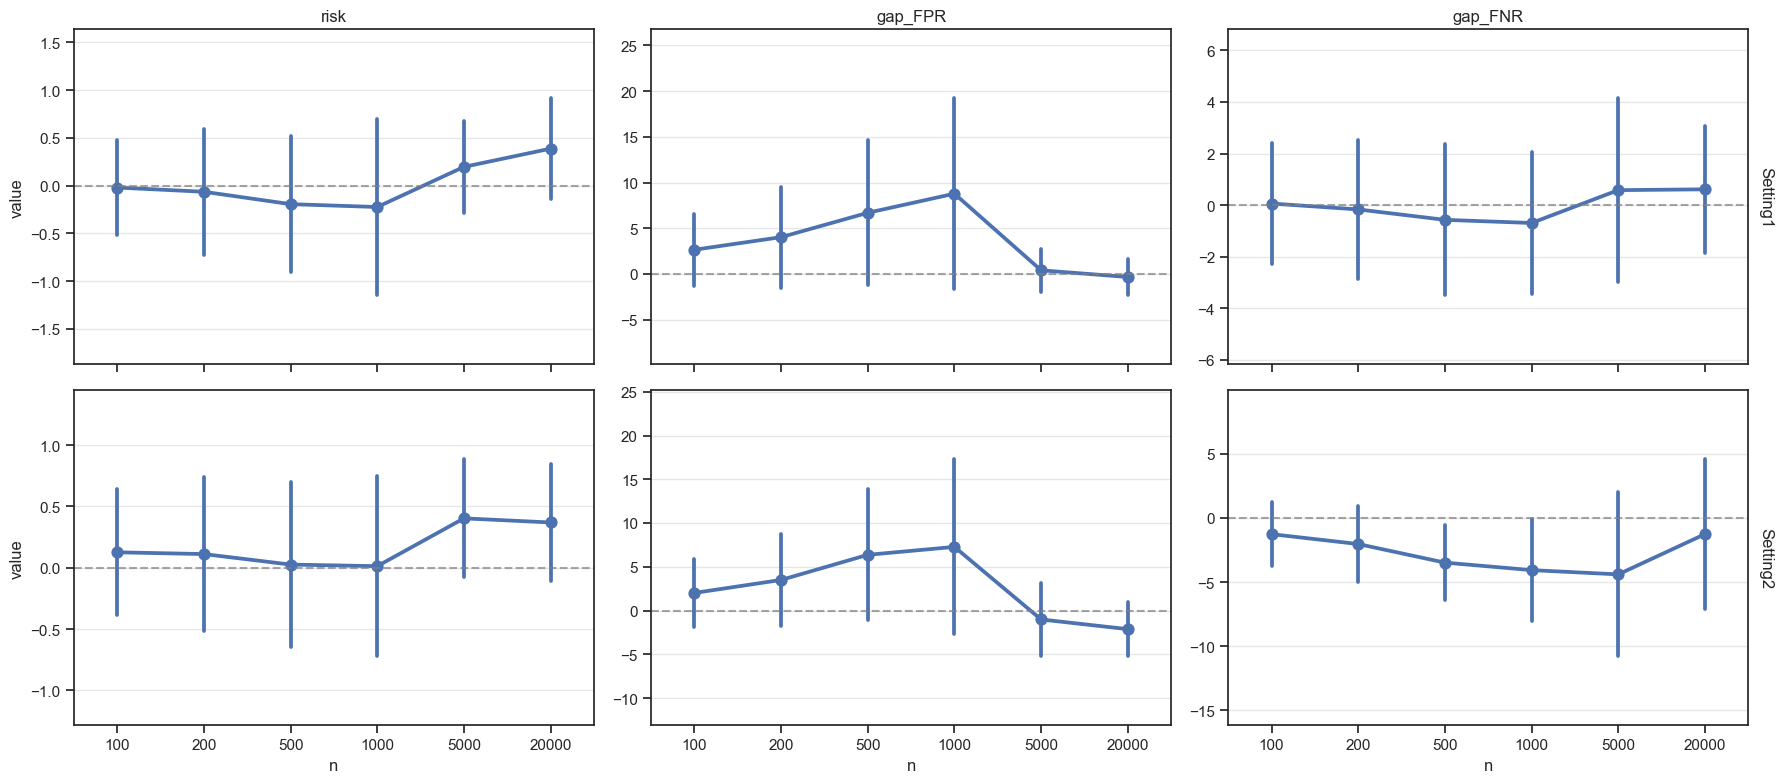

In [ ]:
metrics_comb_50 = transform_metrics(metrics_comb, reference_col='optimal_value', scale=0.5)
metrics_comb_50.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_50.csv'), index = False)

plot_metrics(metrics_comb_50, x='n', y='value', row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value', centered=True,
              draw_custom_errorbars=False, max_ticks=6, height=4, aspect=1.5)

### Scaled by $n^{0.75}$

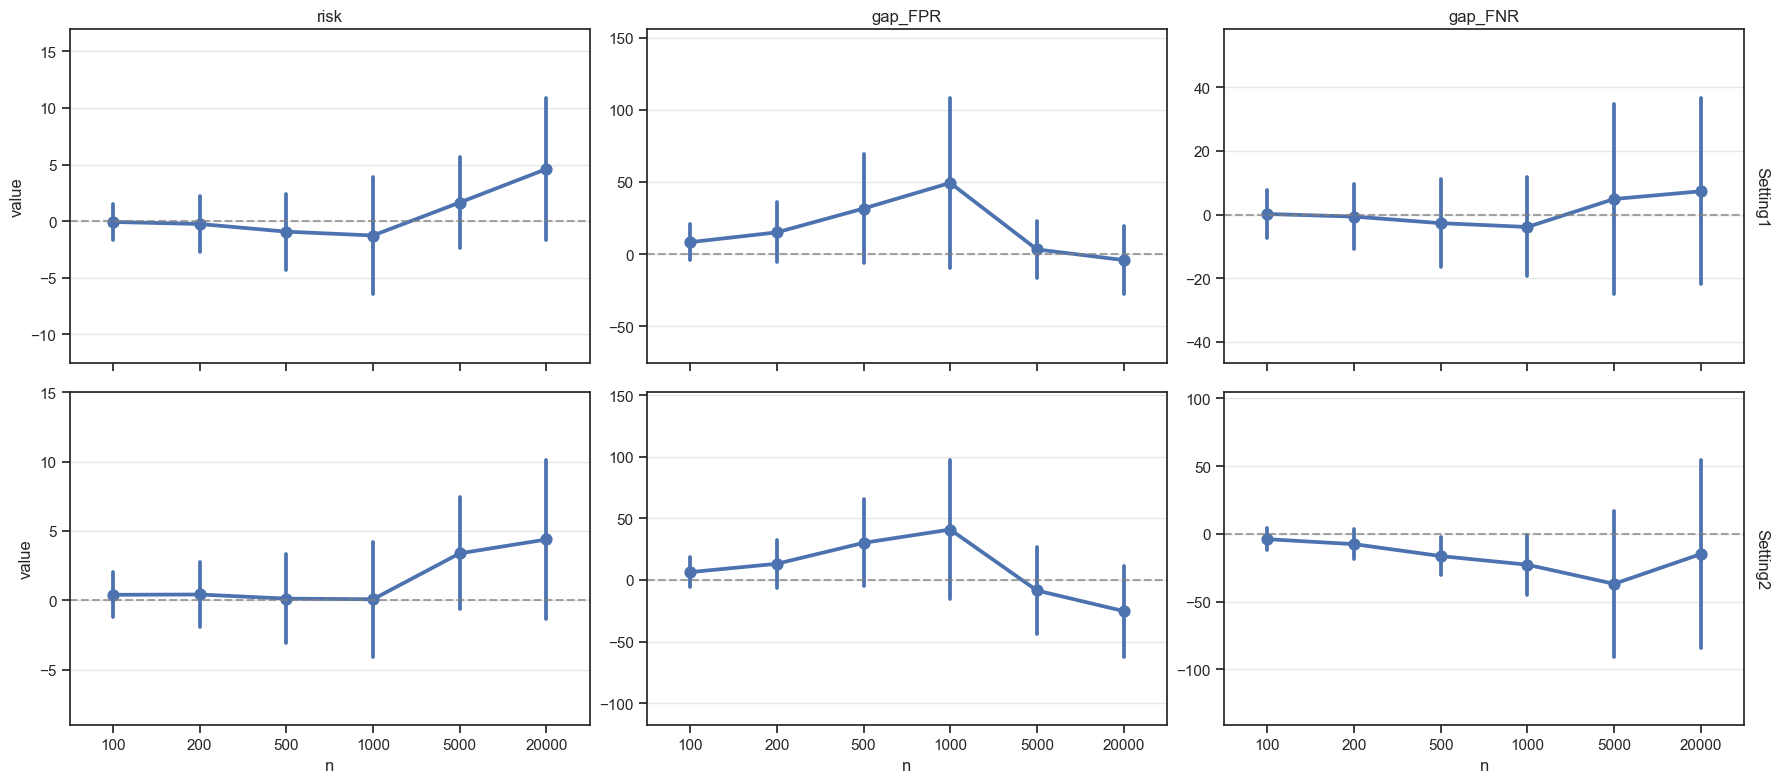

In [ ]:
metrics_comb_75 = transform_metrics(metrics_comb, reference_col='optimal_value', scale=0.75)
metrics_comb_75.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_75.csv'), index = False)

plot_metrics(metrics_comb_75, x='n', y='value', row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value', centered=True,
              draw_custom_errorbars=False, max_ticks=6, height=4, aspect=1.5)

### Scaled by $n$

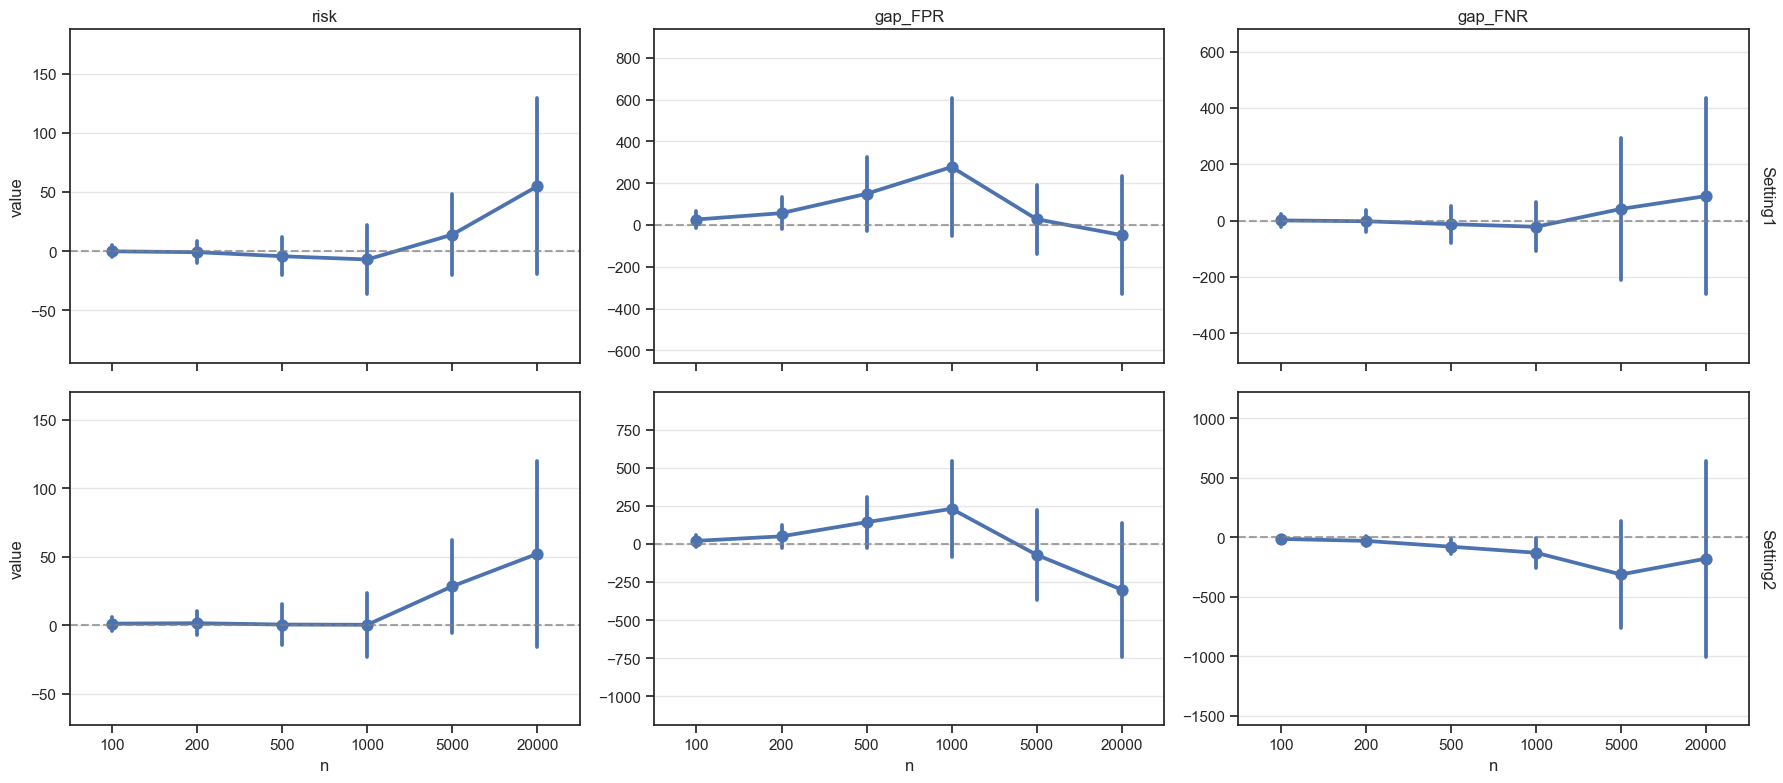

In [50]:
metrics_comb_100 = transform_metrics(metrics_comb, reference_col='optimal_value', scale=1)
metrics_comb_100.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_100.csv'), index = False)

plot_metrics(metrics_comb_100, x='n', y='value', row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value', centered=True,
              draw_custom_errorbars=False, max_ticks=6, height=4, aspect=1.5)

## Get estimated fair predictors: plugin

In [51]:
## Same parameters as for the doubly robust simulations
n_arr = [100, 200, 500, 1000, 5000, 20000]
mc_reps = 500
noise_coef = 30

### Setting 1: equal epsilon values

In [52]:
res1_pi = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.05,
                   epsilon_neg = 0.05, outcome = 'muhat0') for nn in n_arr]
with open(os.path.join(OUTPATH, 'task1/res1_pi.pickle'), 'wb') as file_out:
    pickle.dump(res1_pi, file_out)

Simulating theta-hat for sample size 100 with 500 repetitions...
Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [53]:
metrics1_pi = simulate_task1_metrics_to_df(res1_pi, n_arr, 'Setting1', data_val)
metrics1_pi = add_reference_values(metrics1_pi, metrics_best_1, new_col='optimal_value')
metrics1_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics1_pi.csv'), index = False)

Evaluating metrics for given values of theta: 100%|██████████| 3000/3000 [03:00<00:00, 16.60it/s]


### Setting 2: different epsilon values

In [54]:
res2_pi = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.10,
                   epsilon_neg = 0.20, outcome = 'muhat0') for nn in n_arr]
with open(os.path.join(OUTPATH, 'task1/res2_pi.pickle'), 'wb') as file_out:
    pickle.dump(res1_pi, file_out)

Simulating theta-hat for sample size 100 with 500 repetitions...
Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [55]:
metrics2_pi = simulate_task1_metrics_to_df(res2_pi, n_arr, 'Setting2', data_val)
metrics2_pi = add_reference_values(metrics2_pi, metrics_best_2, new_col='optimal_value')
metrics2_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics2_pi.csv'), index = False)

Evaluating metrics for given values of theta: 100%|██████████| 3000/3000 [02:55<00:00, 17.08it/s]


### Setting 3: no fairness constraints

In [56]:
res3_pi = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 1.0,
                   epsilon_neg = 1.0, outcome = 'muhat0') for nn in n_arr]
with open(os.path.join(OUTPATH, 'task1/res3_pi.pickle'), 'wb') as file_out:
    pickle.dump(res3_pi, file_out)

Simulating theta-hat for sample size 100 with 500 repetitions...
Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [57]:
metrics3_pi = simulate_task1_metrics_to_df(res3_pi, n_arr, 'Setting3', data_val)
metrics3_pi = add_reference_values(metrics3_pi, metrics_best_3, new_col='optimal_value')
metrics3_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics3_pi.csv'), index = False)

Evaluating metrics for given values of theta: 100%|██████████| 3000/3000 [02:58<00:00, 16.78it/s]


## Plot combined results: plugin

### Unscaled

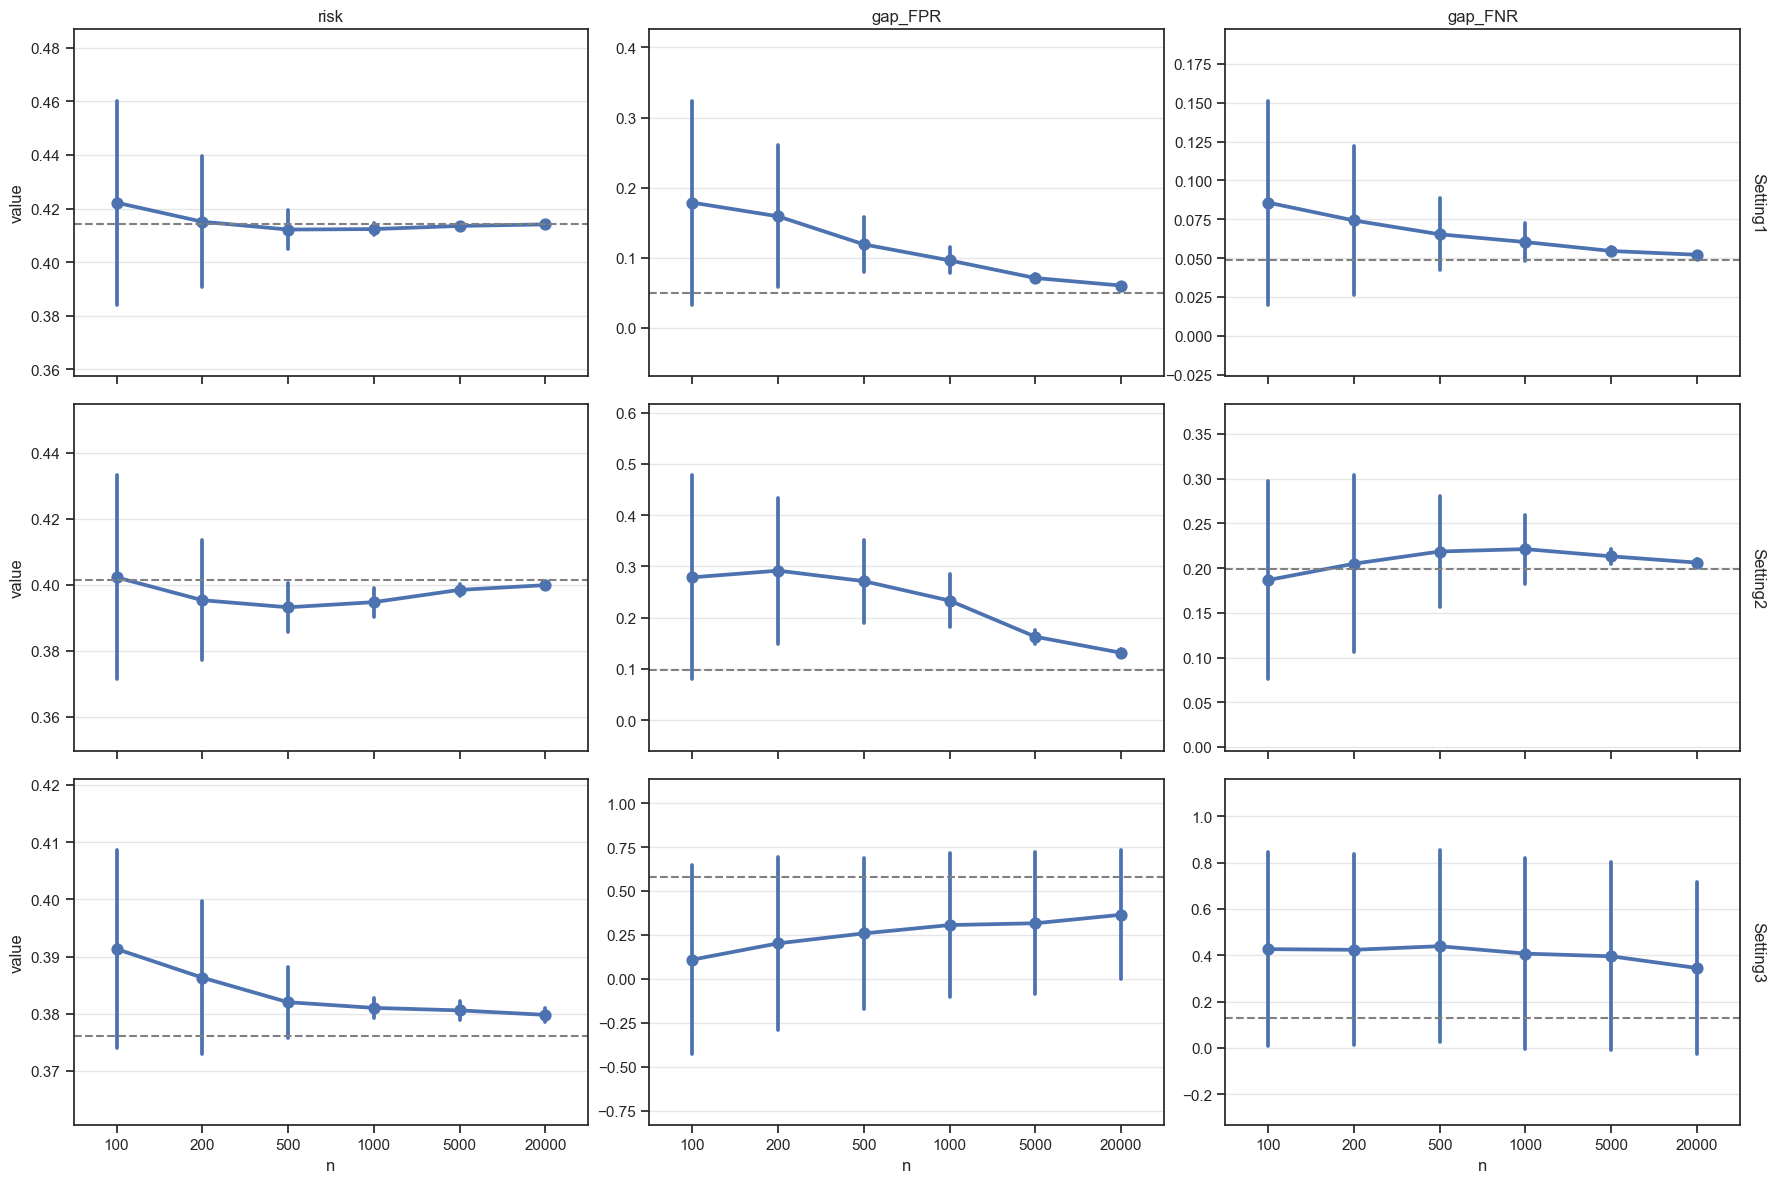

In [64]:
metrics_comb_pi = pd.concat([metrics1_pi, metrics2_pi, metrics3_pi])
metrics_comb_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics_combined_pi.csv'), index = False)

plot_metrics(metrics_comb_pi, x='n', y='value', row='setting', col='metric',
              row_order=['Setting1', 'Setting2', 'Setting3'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value', centered=False,
                 draw_custom_errorbars=False, max_ticks=6,
                 categorical_x=True, height=4, aspect=1.5)

### Scaled by $n^{0.25}$

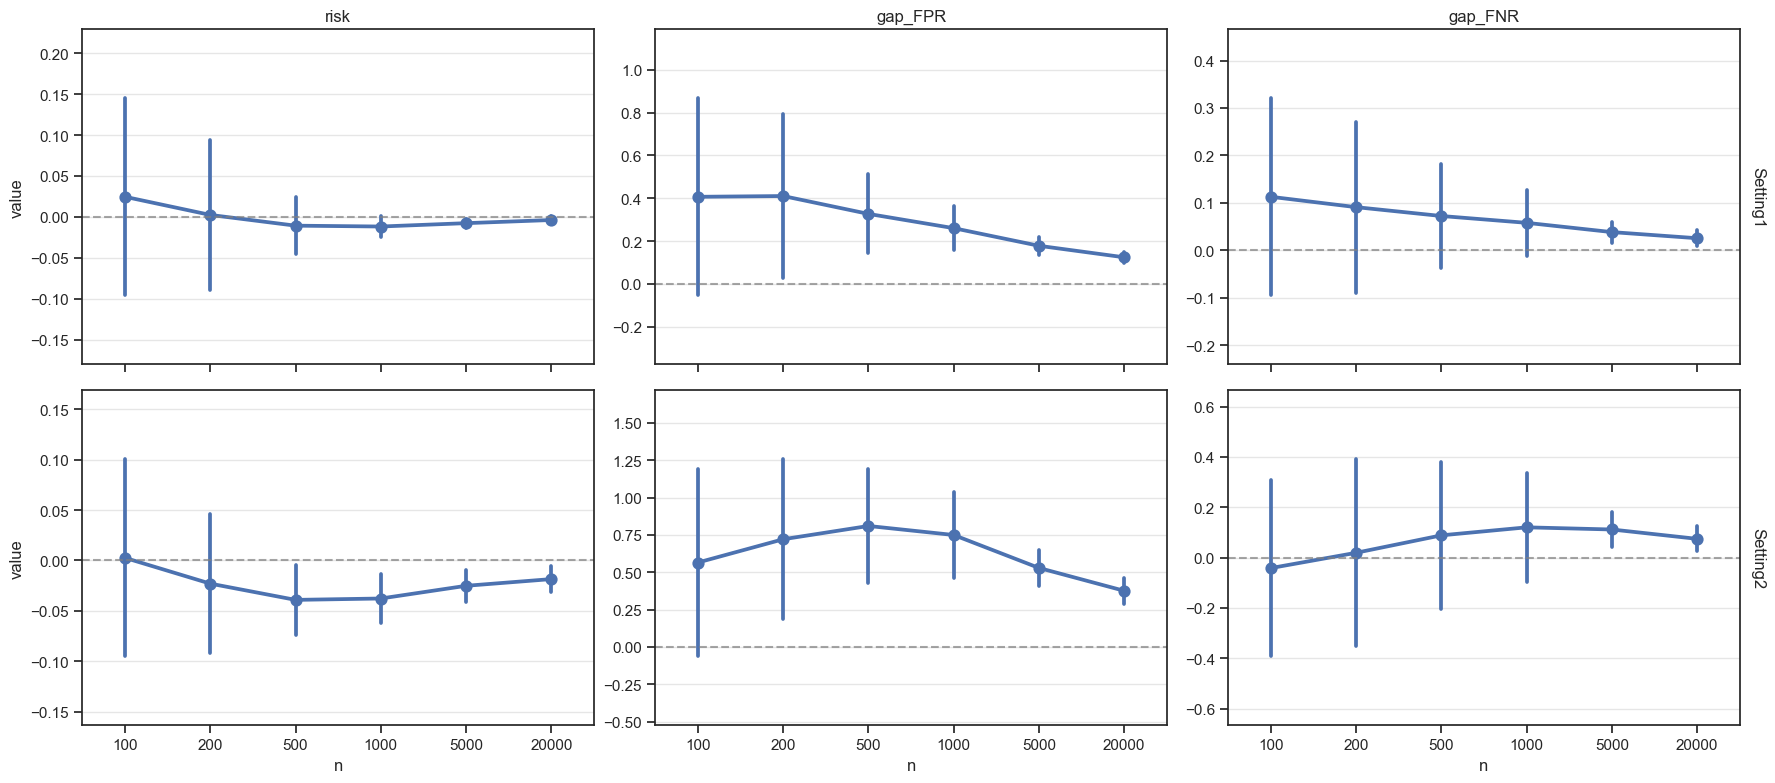

In [65]:
metrics_comb_25_pi = transform_metrics(metrics_comb_pi, reference_col='optimal_value', scale=0.25)
metrics_comb_25_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_25_pi.csv'), index = False)

plot_metrics(metrics_comb_25_pi, x='n', y='value', row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value', centered=True,
              draw_custom_errorbars=False, max_ticks=6, height=4, aspect=1.5)

### Scaled by $\sqrt{n}$

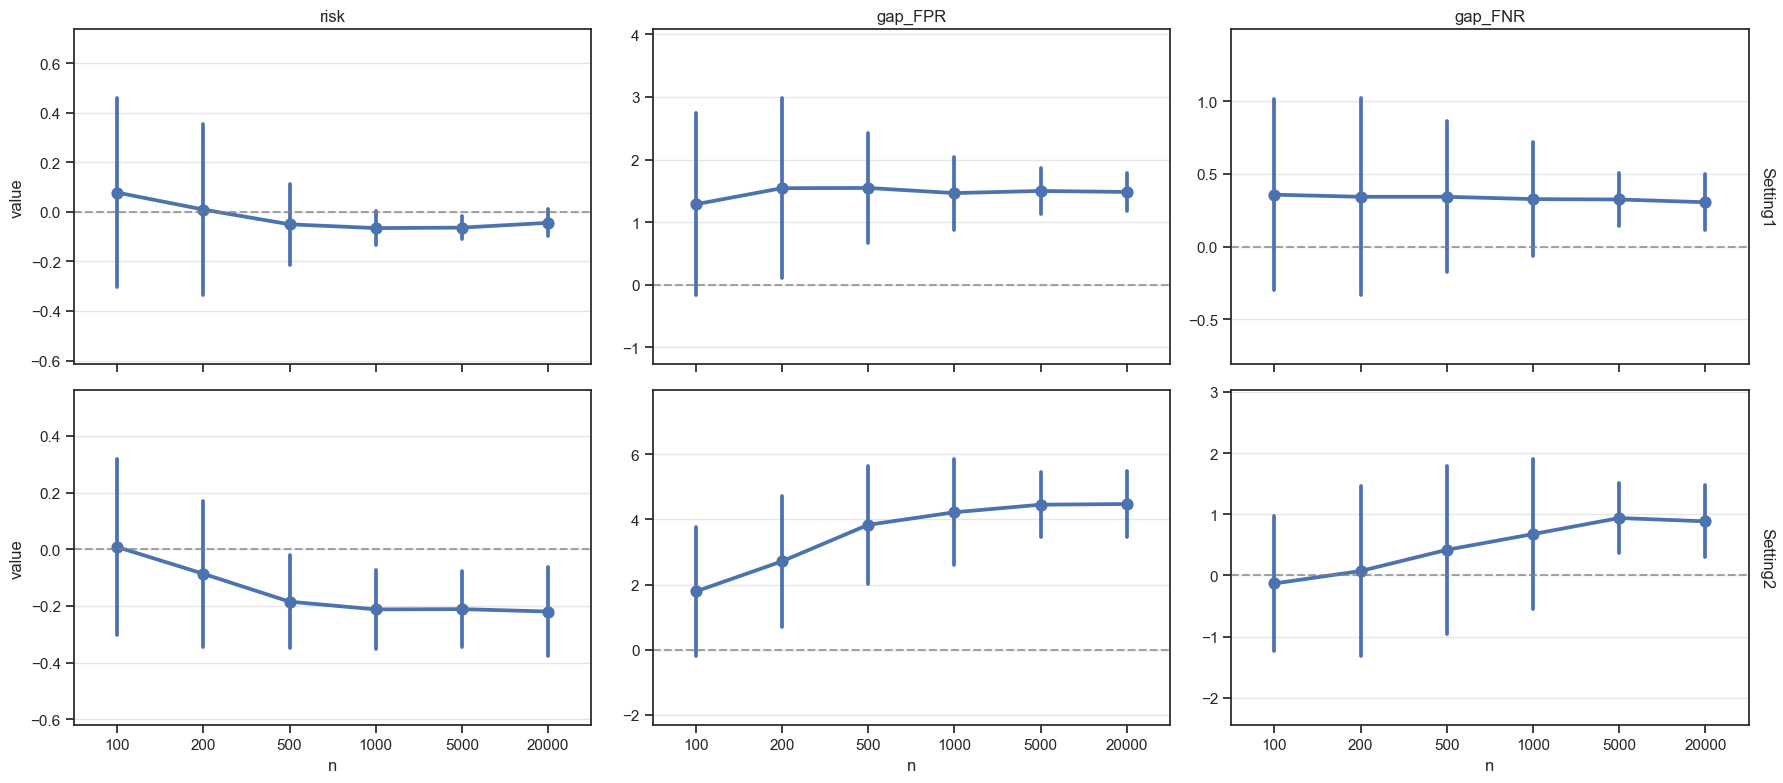

In [66]:
metrics_comb_50_pi = transform_metrics(metrics_comb_pi, reference_col='optimal_value', scale=0.50)
metrics_comb_50_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_50_pi.csv'), index = False)

plot_metrics(metrics_comb_50_pi, x='n', y='value', row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value', centered=True,
              draw_custom_errorbars=False, max_ticks=6, height=4, aspect=1.5)

### Scaled by $n^{0.75}$

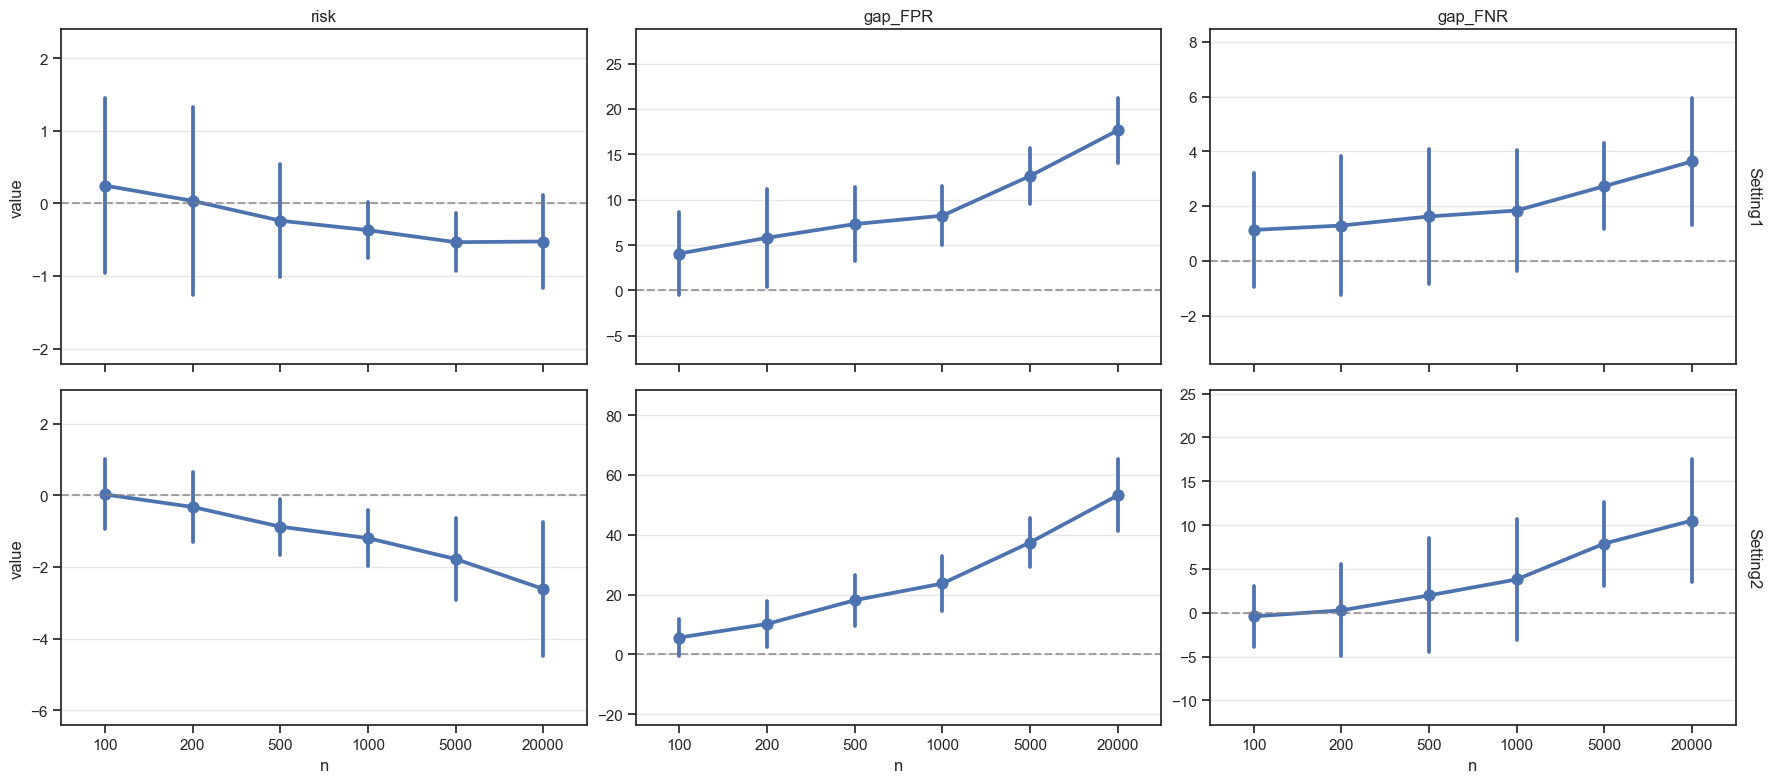

In [67]:
metrics_comb_75_pi = transform_metrics(metrics_comb_pi, reference_col='optimal_value', scale=0.75)
metrics_comb_75_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_75_pi.csv'), index = False)

plot_metrics(metrics_comb_75_pi, x='n', y='value', row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value', centered=True,
              draw_custom_errorbars=False, max_ticks=6, height=4, aspect=1.5)

### Scaled by $n$

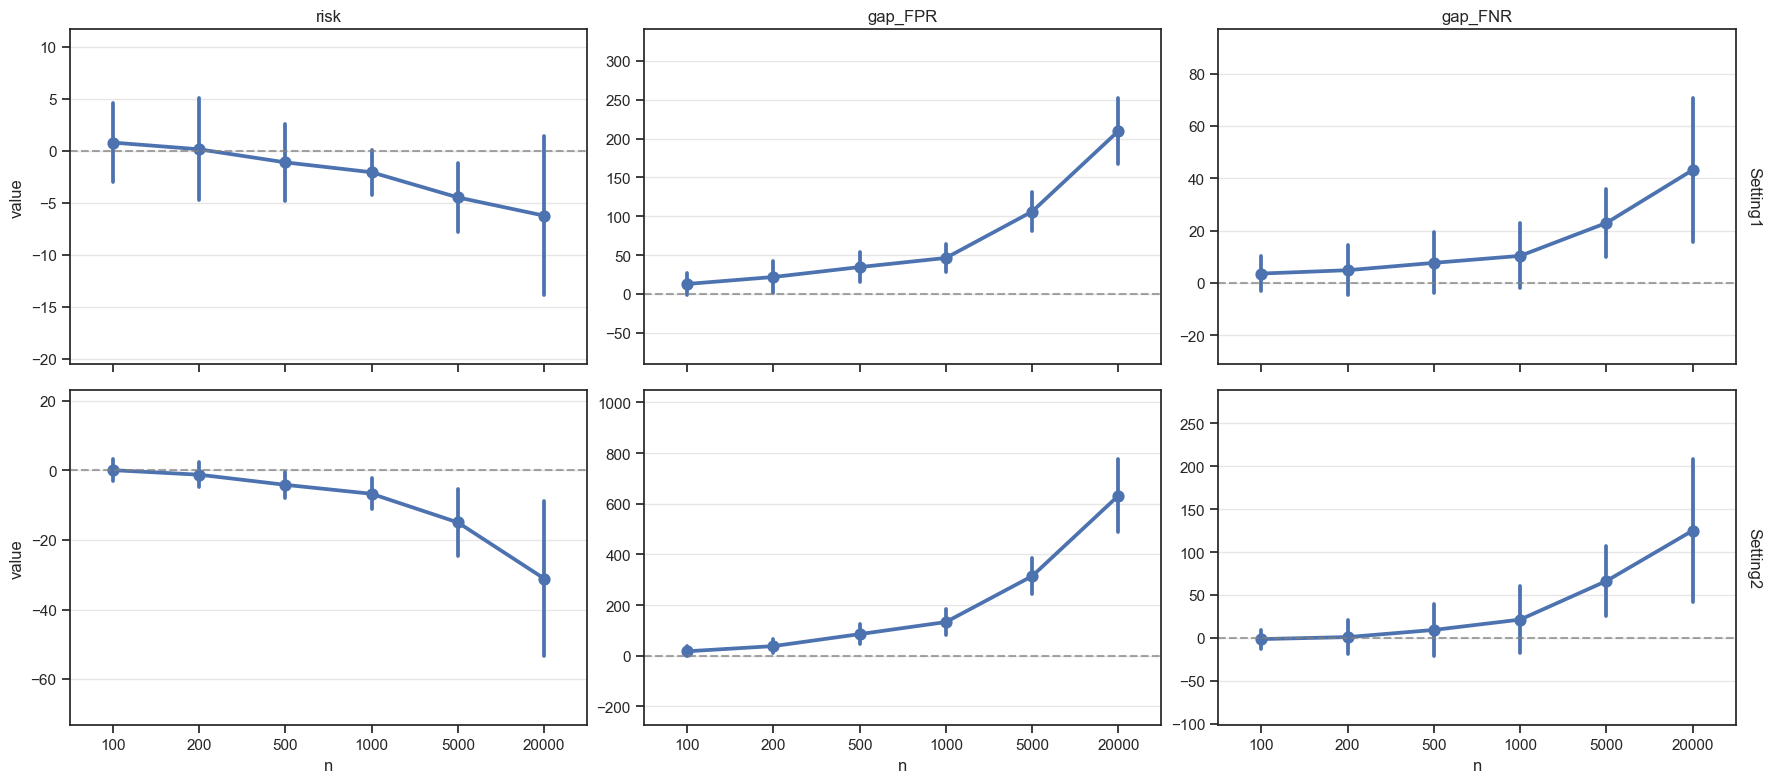

In [68]:
metrics_comb_100_pi = transform_metrics(metrics_comb_pi, reference_col='optimal_value', scale=1)
metrics_comb_100_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_100_pi.csv'), index = False)

plot_metrics(metrics_comb_100_pi, x='n', y='value', row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value', centered=True,
              draw_custom_errorbars=False, max_ticks=6, height=4, aspect=1.5)

# Task 2 Simulations
Here the goal is to understand the behavior of the counterfactual risk and fairness estimators. We calculate confidence intervals only to check the coverage, because we want to know confirm that they are (asymptotically) valid.

In [69]:
## Metrics for the input predictor, for potential plotting purposes
metrics_pre = metrics_post_simple([0, 1, 0, 1], data_val, outcome = 'mu0', 
                                  ci=0.95, ci_scale='logit')
risk_pre = metrics_pre.query("metric=='risk'")['value'].values[0]

## Simulations setup
Here we have two "scenarios" representing two different values of $\theta$ which index two different post-processed predictors. We use the word "scenario" here to distinguish from "settings" in the Task 1 simulations above.
- Scenario 1: a $\theta$ where each of the coefficients were sampled uniformly at random in $[0, 1]$
- Scenario 2: a $\theta$ where one of the coefficients is set to the max possible value of 1 and one is set to the min possible value of 0

In [70]:
theta1 = [0.64, 0.39, 0.53, 0.46]           # Scenario 1
theta2 = [0.74, 1.0, 0, 0.8]                # Scenario 2
n_arr = [100, 200, 500, 1000, 5000, 20000]  # Sample sizes
mc_reps = 500                               # Monte Carlo iterations
noise_coef = 30                             # Noise coefficient for nuisance parameters in simulations

In [71]:
# "True" values for the scenarios
metrics_post1 = metrics_post_simple(theta1, data_val, outcome = 'mu0')
metrics_post2 = metrics_post_simple(theta2, data_val, outcome = 'mu0')

metrics_post1.to_csv(os.path.join(OUTPATH, 'task2/metrics_post1.csv'), index = False)
metrics_post2.to_csv(os.path.join(OUTPATH, 'task2/metrics_post2.csv'), index = False)

In [72]:
# Extract relevant metrics
risk_post1 = metrics_post1.loc[metrics_post1['metric'] == 'risk', 'value'].values[0]
risk_change_post1 = metrics_post1.loc[metrics_post1['metric'] == 'risk_change', 'value'].values[0]
gap_FPR_post1 = metrics_post1.loc[metrics_post1['metric'] == 'gap_FPR', 'value'].values[0]
gap_FNR_post1 = metrics_post1.loc[metrics_post1['metric'] == 'gap_FNR', 'value'].values[0]

risk_post2 = metrics_post2.loc[metrics_post2['metric'] == 'risk', 'value'].values[0]
risk_change_post2 = metrics_post2.loc[metrics_post2['metric'] == 'risk_change', 'value'].values[0]
gap_FPR_post2 = metrics_post2.loc[metrics_post2['metric'] == 'gap_FPR', 'value'].values[0]
gap_FNR_post2 = metrics_post2.loc[metrics_post2['metric'] == 'gap_FNR', 'value'].values[0]

## Estimate metrics: doubly robust

### Scenario 1

In [73]:
metrics_est1 = simulate_task2(theta1, noise_coef, n_arr, mc_reps, data_params,
                            outcome = 'phihat', ci = 0.95, ci_scale = 'logit')
metrics_est1 = add_reference_values(metrics_est1, metrics_post1, new_col='true_value')
metrics_est1['scenario'] = 'Scenario1'
metrics_est1.to_csv(os.path.join(OUTPATH, 'task2/metrics_est1_logit.csv'), index = False)

In [74]:
# Get confidence interval coverage
cov_means1 = coverage(metrics_est1, metrics_post1, simplify=True)
cov_means1.to_csv(os.path.join(OUTPATH, 'task2/task2_scenario1_coverage_logit.csv'), index = False)

### Scenario 2

In [75]:
metrics_est2 = simulate_task2(theta2, noise_coef, n_arr, mc_reps, data_params,
                            outcome = 'phihat', ci_scale = 'logit')
metrics_est2 = add_reference_values(metrics_est2, metrics_post2, new_col='true_value')
metrics_est2['scenario'] = 'Scenario2'
metrics_est2.to_csv(os.path.join(OUTPATH, 'task2/metrics_est2_logit.csv'), index = False)

In [76]:
# Get confidence interval coverage
cov_means2 = coverage(metrics_est2, metrics_post2, simplify=True)
cov_means2.to_csv(os.path.join(OUTPATH, 'task2/task2_scenario2_coverage_logit.csv'), index = False)
cov_means2.coverage.median()  # Should be approximately 0.95 across all the CIs

0.956

## Plot combined results: doubly robust

### Unscaled

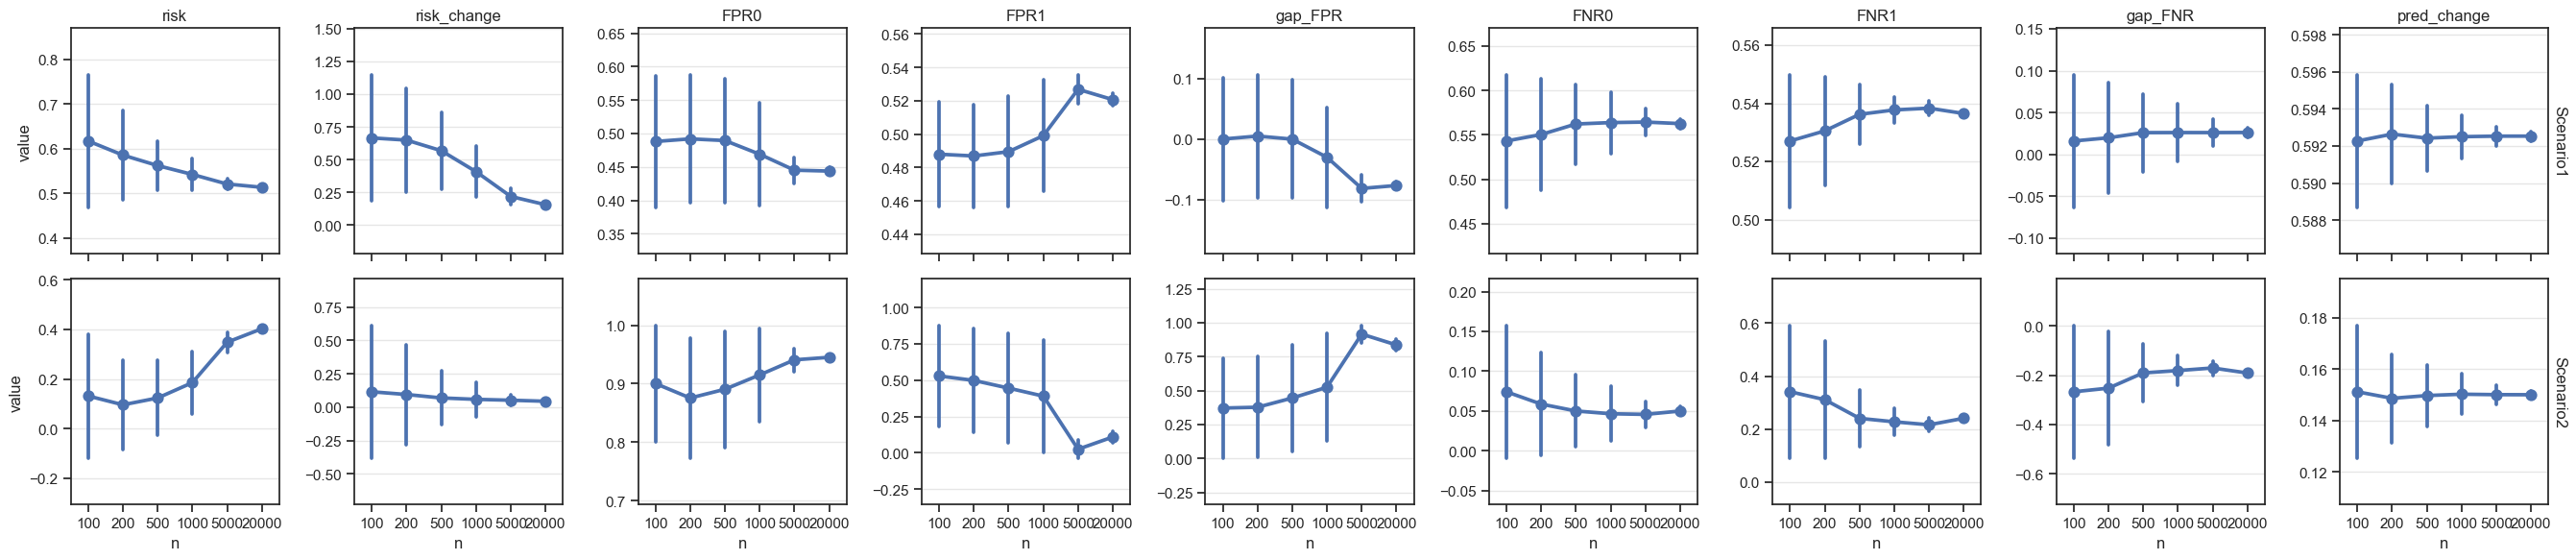

In [79]:
plot_metrics(metrics_est_comb, x='n', y='value', row='scenario', col='metric')

### Scaled by $n^{0.25}$

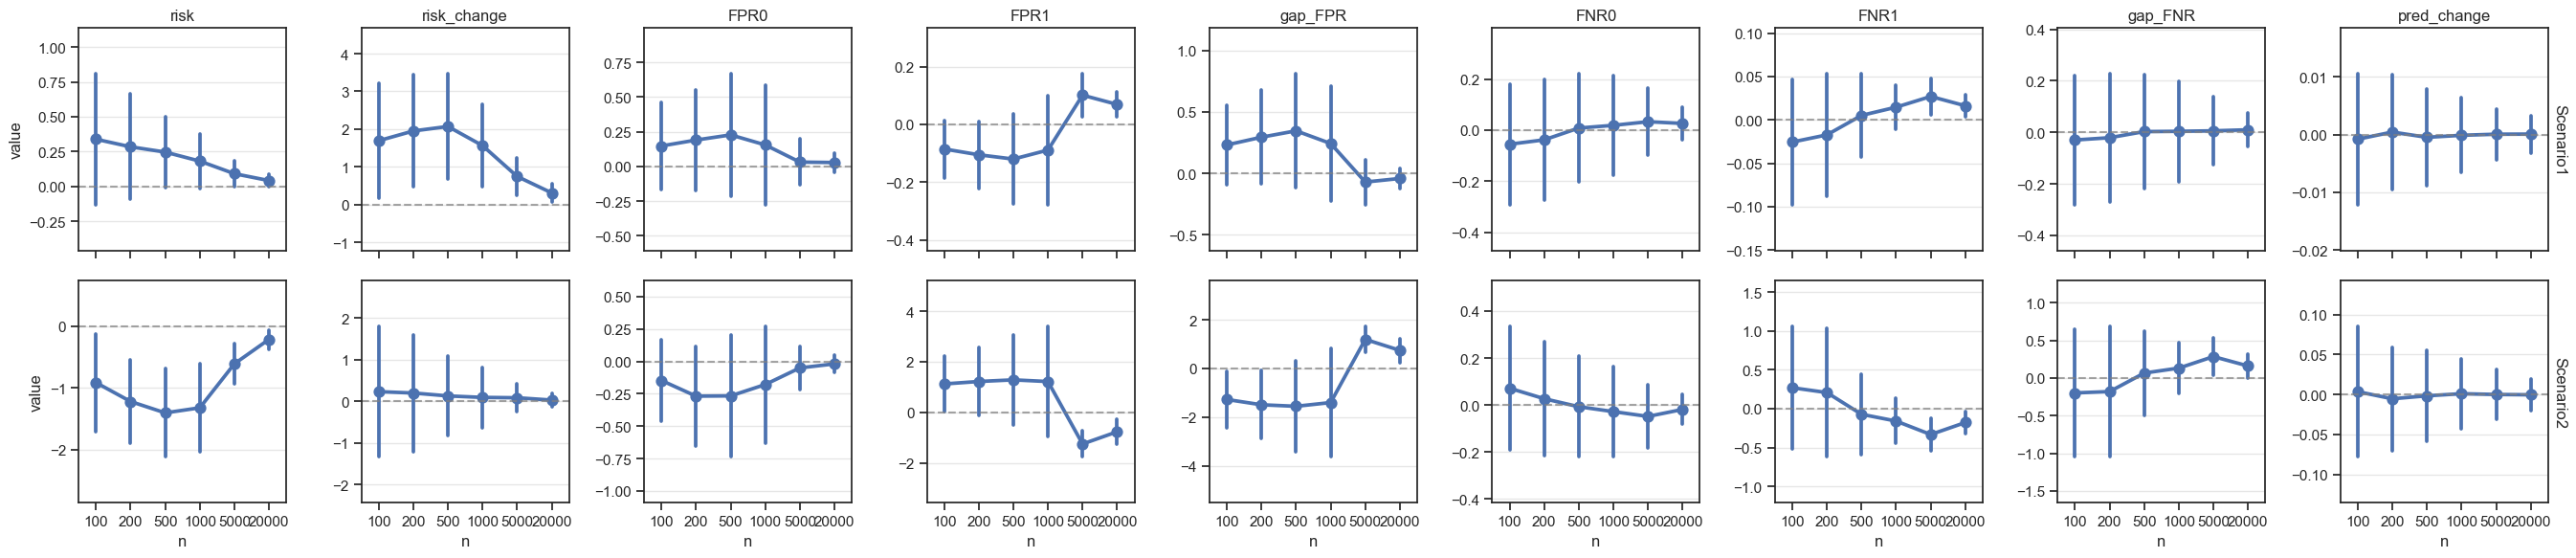

In [80]:
metrics_est_comb_25 = transform_metrics(metrics_est_comb, reference_col='true_value', scale=0.25)
plot_metrics(metrics_est_comb_25, x='n', y='value', row='scenario', col='metric', centered=True)

### Scaled by $\sqrt{n}$

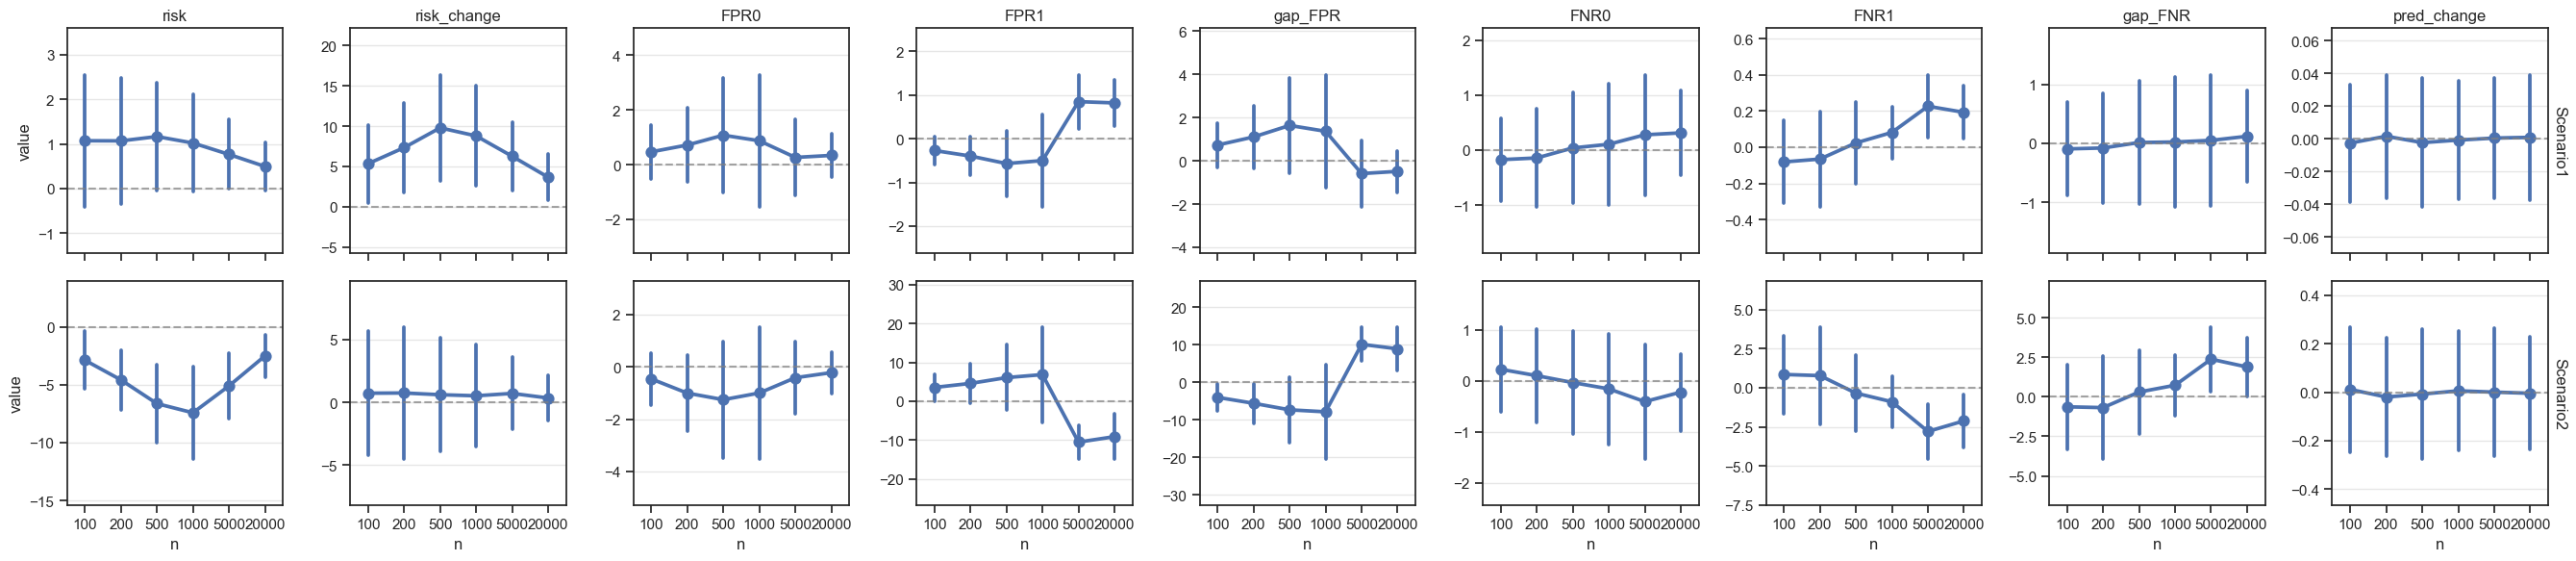

In [81]:
metrics_est_comb_50 = transform_metrics(metrics_est_comb, reference_col='true_value', scale=0.50)
plot_metrics(metrics_est_comb_50, x='n', y='value', row='scenario', col='metric', centered=True)

### Scaled by $n^{0.75}$

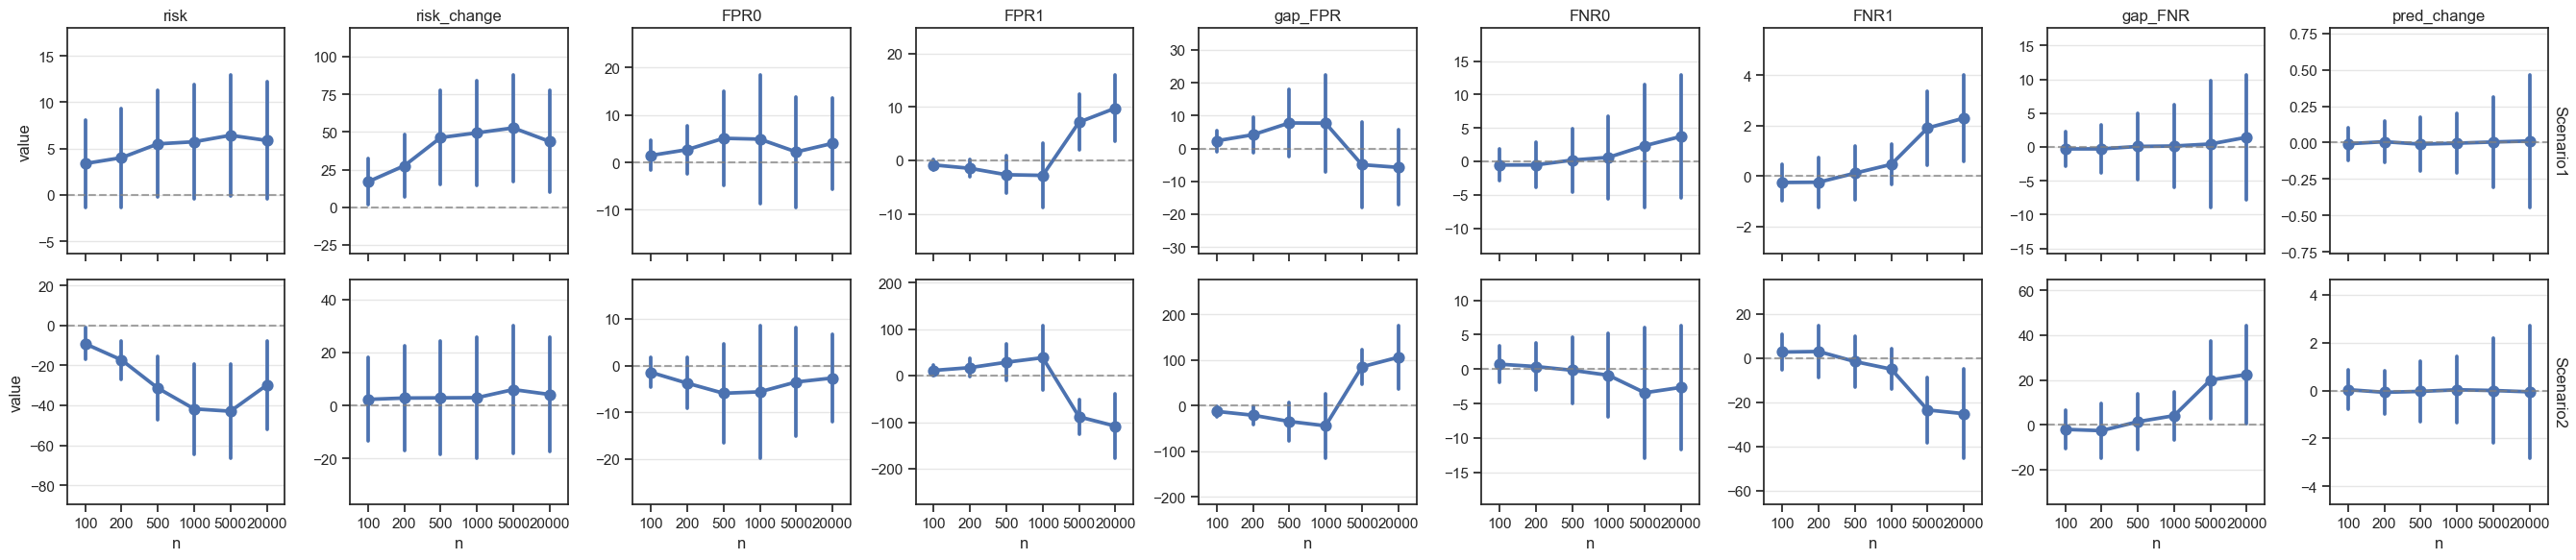

In [82]:
metrics_est_comb_75 = transform_metrics(metrics_est_comb, reference_col='true_value', scale=0.75)
plot_metrics(metrics_est_comb_75, x='n', y='value', row='scenario', col='metric', centered=True)

### Scaled by $n$

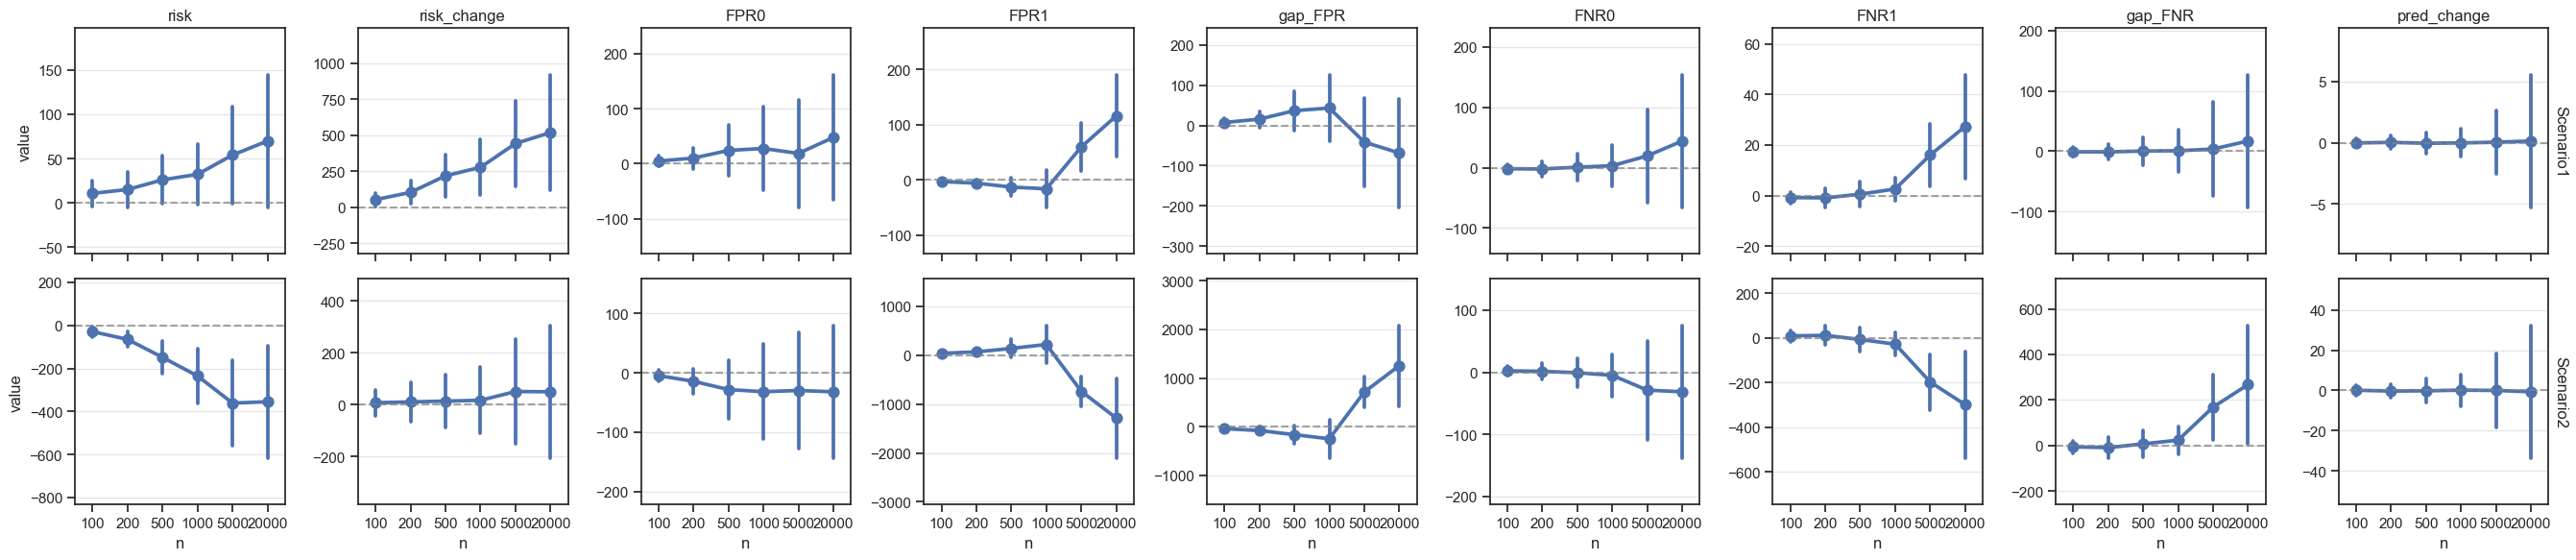

In [83]:
metrics_est_comb_100 = transform_metrics(metrics_est_comb, reference_col='true_value', scale=1.0)
plot_metrics(metrics_est_comb_100, x='n', y='value', row='scenario', col='metric', centered=True)

## Estimate metrics: plugin

### Scenario 1: equal epsilon values

In [85]:
metrics_est1_pi = simulate_task2(theta1, noise_coef, n_arr, mc_reps, data_params, outcome = 'muhat0')
metrics_est1_pi = add_reference_values(metrics_est1_pi, metrics_post1, new_col='true_value')
metrics_est1_pi['scenario'] = 'Scenario1'
metrics_est1_pi.to_csv(os.path.join(OUTPATH, 'task2/metrics_est1_pi_logit.csv'), index = False)

### Scenario 2: different epsilon values

In [86]:
metrics_est2_pi = simulate_task2(theta2, 30, n_arr, mc_reps, data_params, outcome = 'muhat0')
metrics_est2_pi = add_reference_values(metrics_est2_pi, metrics_post2, new_col='true_value')
metrics_est2_pi['scenario'] = 'Scenario2'
metrics_est2_pi.to_csv(os.path.join(OUTPATH, 'task2/metrics_est2_pi_logit.csv'), index = False)

## Plot combined results: plugin

### Unscaled

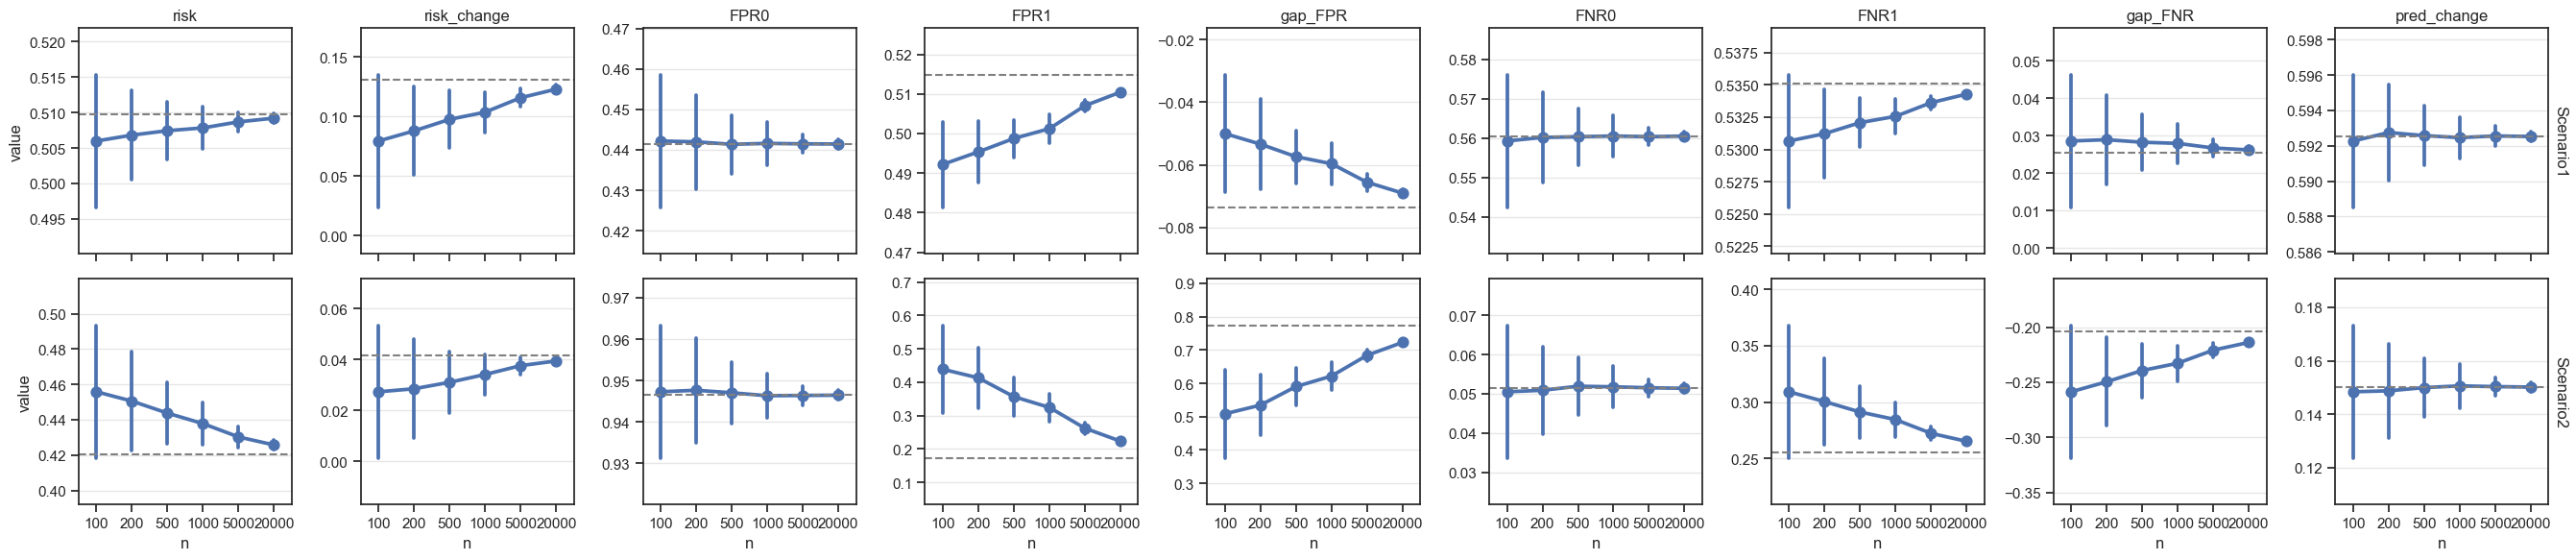

In [87]:
metrics_est_comb_pi = pd.concat([metrics_est1_pi, metrics_est2_pi])
plot_metrics(metrics_est_comb_pi, x='n', y='value', row='scenario', col='metric', reference_col='true_value')

### Scaled by $n^{1/4}$

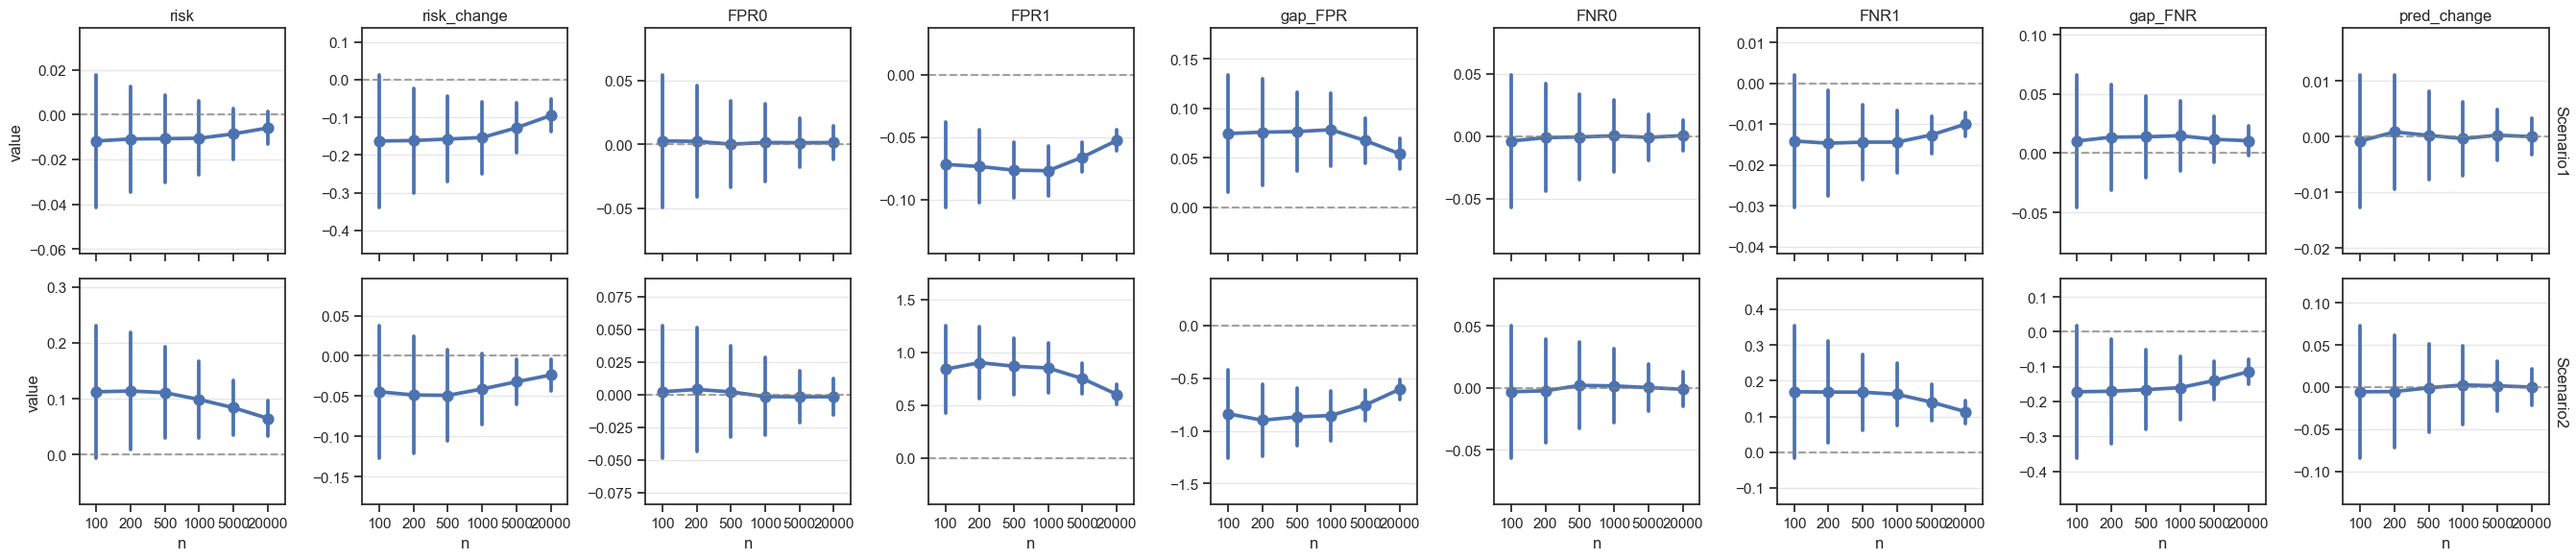

In [88]:
metrics_est_comb_pi_25 = transform_metrics(metrics_est_comb_pi, reference_col='true_value', scale=0.25)
plot_metrics(metrics_est_comb_pi_25, x='n', y='value', row='scenario', col='metric', centered=True)

### Scaled by $\sqrt{n}$

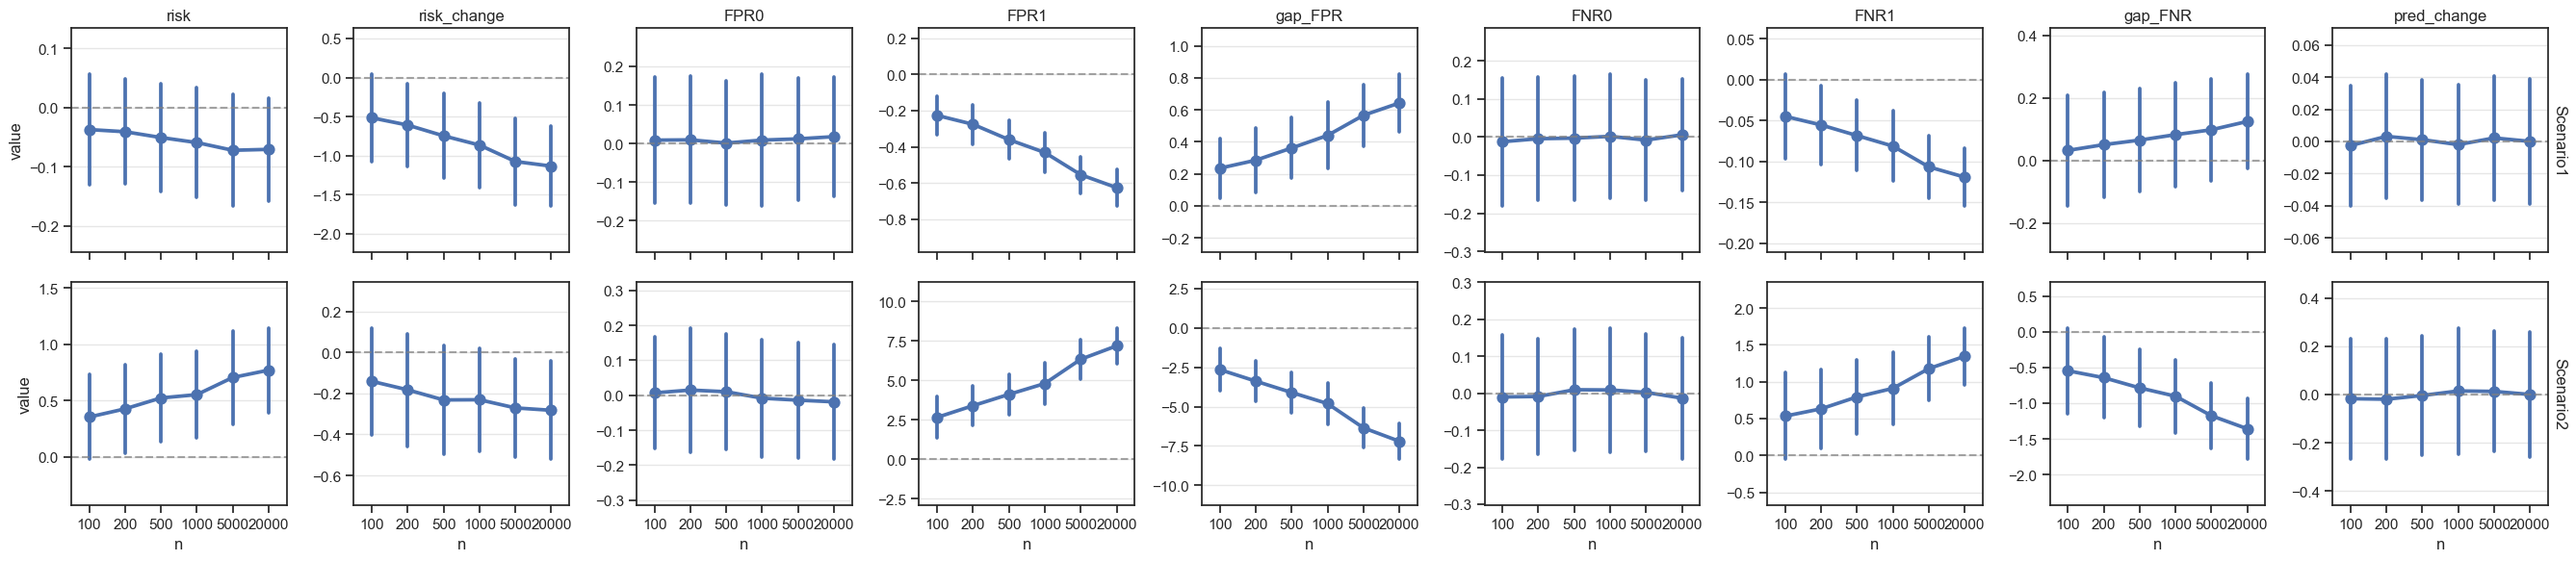

In [89]:
metrics_est_comb_pi_50 = transform_metrics(metrics_est_comb_pi, reference_col='true_value', scale=0.50)
plot_metrics(metrics_est_comb_pi_50, x='n', y='value', row='scenario', col='metric', centered=True)

### Scaled by $n^{0.75}$

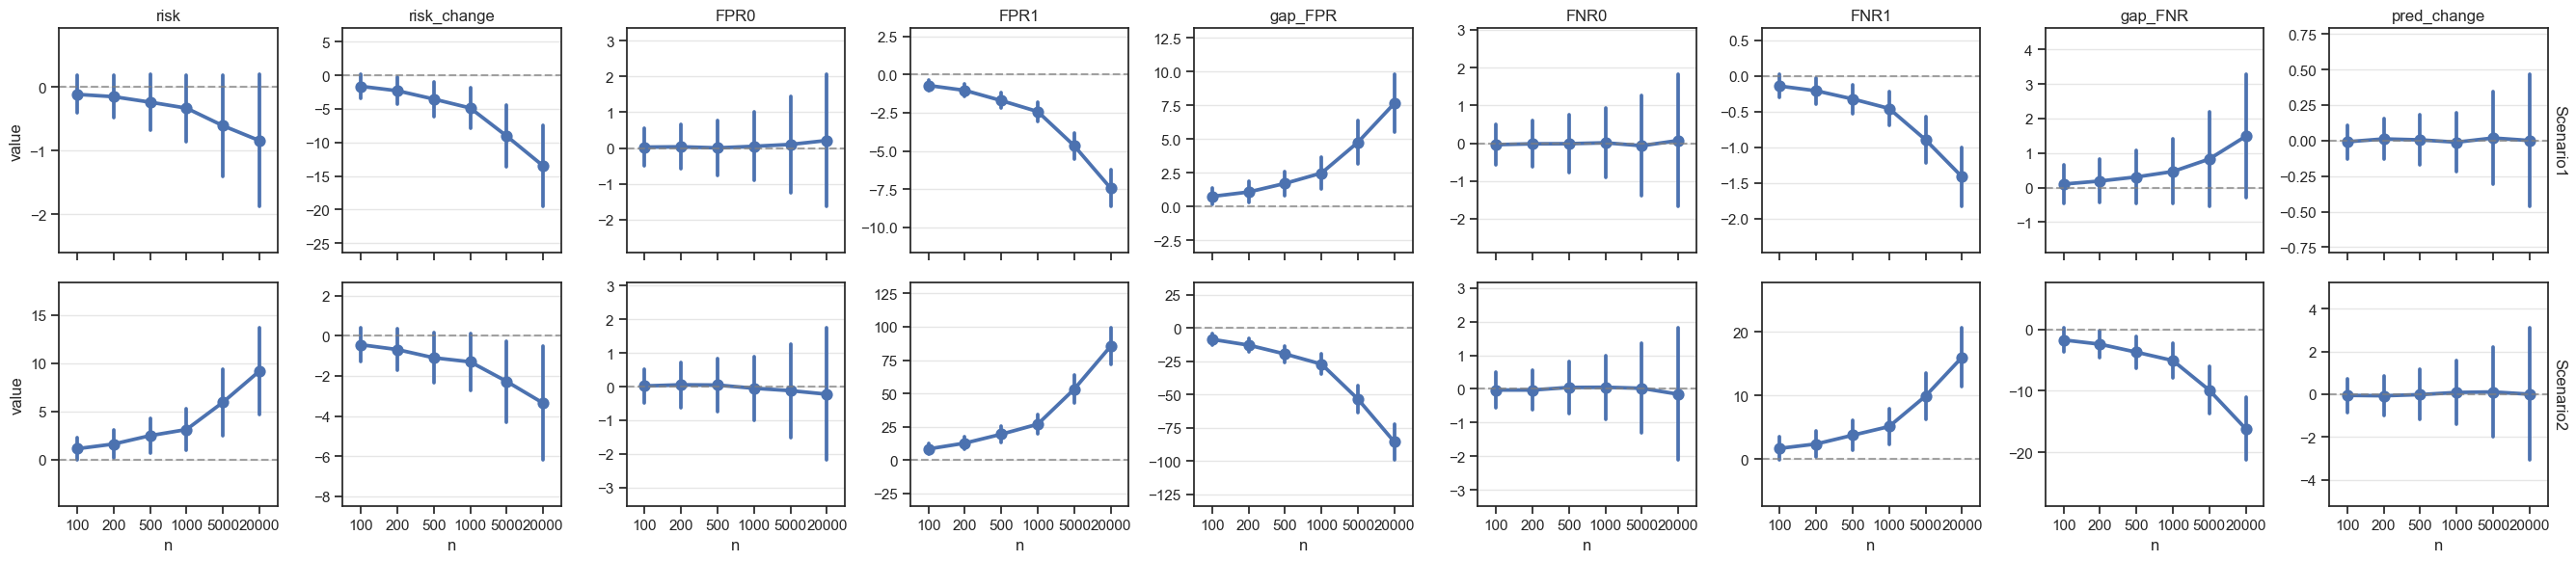

In [90]:
metrics_est_comb_pi_75 = transform_metrics(metrics_est_comb_pi, reference_col='true_value', scale=0.75)
plot_metrics(metrics_est_comb_pi_75, x='n', y='value', row='scenario', col='metric', centered=True)

### Scaled by $n$

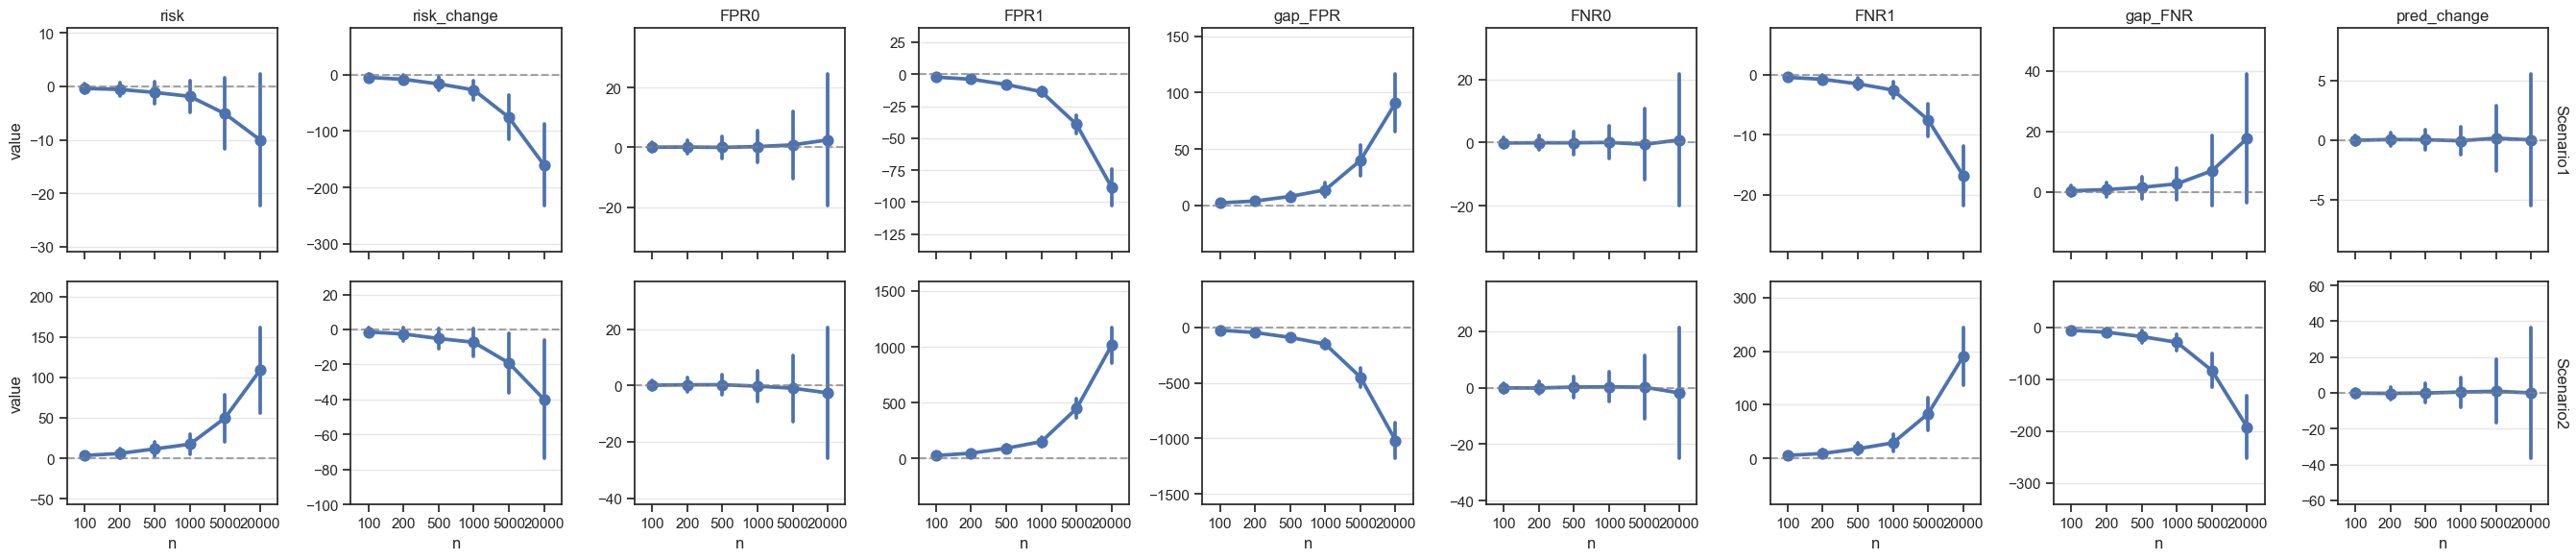

In [91]:
metrics_est_comb_pi_100 = transform_metrics(metrics_est_comb_pi, reference_col='true_value', scale=1.0)
plot_metrics(metrics_est_comb_pi_100, x='n', y='value', row='scenario', col='metric', centered=True)

# Plots for paper
- Only the explanatory plot (Figure 1) and the plot of performance-fairness tradeoffs (Figure 3) are generated here. 
- The other plots for the paper were generated in R using `ggplot`, from the results above.

## Explanatory Figure for Intro

In [92]:
def intro_data_pre(n, pA, need_A, strength, prob_treated):
    """Generate data."""
    A = np.random.binomial(1, p = pA, size = n)
    Y0 = np.random.binomial(1, p = A*need_A[0] + (1 - A)*need_A[1], size = n)
    Y1 = np.copy(Y0)
    Y1[Y0 == 1] = np.random.binomial(1, 1 - strength, size = np.sum(Y0))
    AY0 = pd.DataFrame({'A': A, 'Y0': Y0})
    D_probs = (1-A)*(1-Y0)*prob_treated[0] + (1-A)*Y0*prob_treated[1] +\
              A*(1-Y0)*prob_treated[2] + A*Y0*prob_treated[3]
    D = np.random.binomial(1, D_probs)
    Y = D*Y1 + (1 - D)*Y0
    out = np.concatenate([A.reshape((n,1)), Y0.reshape((n,1)),
                          Y1.reshape((n,1)), D.reshape((n,1)), 
                          Y.reshape((n,1))], axis = 1)
    out = pd.DataFrame(out, columns = ['A', 'Y0', 'Y1', 'D', 'Y'])
    
    return out

In [93]:
def intro_data_post(n, pA, need_A, strength, prob_treated_pre, pred_rates):
    out = intro_data_pre(n, pA, need_A, strength, prob_treated_pre)
    D_new_probs = pred_rates[(0, 0, 'FPR')]*(1 - out.Y)*(1 - out.A) +\
                  pred_rates[(0, 1, 'TPR')]*out.Y*(1 - out.A) +\
                  pred_rates[(1, 0, 'FPR')]*(1 - out.Y)*out.A +\
                  pred_rates[(1, 1, 'TPR')]*out.Y*out.A
    D = np.random.binomial(1, D_new_probs)
    Y = D*out.Y1 + (1 - D)*out.Y0
    out['D'] = D
    out['Y'] = Y
    
    return out

In [94]:
def calc_errors(dat, pred_rates):
    """Compute P(S = 1|Y(0) = 1, A) for different predictors S.
    
    Args:
      pred_rates: P(S = 1|A, Y), a Series with index (A, Y). 
    """
    reg_Y = dat.loc[dat.Y0 == 1].groupby('A')['Y'].mean()
    cTPR0 = pred_rates[(0, 1, 'TPR')]*reg_Y[0] + pred_rates[(0, 0, 'FPR')]*(1 - reg_Y[0])
    cTPR1 = pred_rates[(1, 1, 'TPR')]*reg_Y[1] + pred_rates[(1, 0, 'FPR')]*(1 - reg_Y[1])
    
    reg_Y = dat.loc[dat.Y0 == 0].groupby('A')['Y'].mean()
    cFPR0 = pred_rates[(0, 1, 'TPR')]*reg_Y[0] + pred_rates[(0, 0, 'FPR')]*(1 - reg_Y[0])
    cFPR1 = pred_rates[(1, 1, 'TPR')]*reg_Y[1] + pred_rates[(1, 0, 'FPR')]*(1 - reg_Y[1])
    
    out = pd.DataFrame({'A': [0, 1], 'cTPR': [cTPR0, cTPR1], 'cFPR': [cFPR0, cFPR1]})
    return out

In [95]:
def calc_success(dat):
    """Compute P(Y = 0|A), the probability of success for groups A."""
    out = (1 - dat.groupby('A')['Y'].mean()).to_frame()
    return out

In [96]:
n = 50000
pA = 0.7
need_A = [0.4, 0.2]

index = pd.MultiIndex.from_tuples([(0, 0, 'FPR'), (0, 1, 'TPR'), 
                                   (1, 0, 'FPR'), (1, 1, 'TPR')],
                                  names=['A', 'Y', 'type'])

prob_treated = [0.3, 0.6, 0.2, 0.4]
rates_unconstrained = pd.Series([0.2, 0.5, 0.6, 0.7], index = index)
rates_EO = pd.Series([0.1, 0.8, 0.1, 0.8], index = index)
opportunity_rates = np.array(prob_treated)[[1, 3]]

In [97]:
strength = np.linspace(0, 1, 21)
res_obs = [None]*len(strength)
res_EO_pre = [None]*len(strength)
res_EO_post = [None]*len(strength)

for i, s in enumerate(strength):
    dat_pre = intro_data_pre(50000, pA, need_A, s, prob_treated)
    dat_post = intro_data_post(50000, pA, need_A, s, prob_treated, rates_EO)
    res_EO_pre[i] = calc_errors(dat_pre, rates_EO)
    res_obs[i] = calc_success(dat_pre)
    res_EO_post[i] = calc_success(dat_post)

res_obs = pd.concat(res_obs, axis = 0, keys = strength)
res_obs = res_obs.reset_index().rename(columns = {'level_0': 'strength'})
res_EO_pre = pd.concat(res_EO_pre, axis = 0, keys = strength)
res_EO_pre = res_EO_pre.reset_index().rename(columns = {'level_0': 'strength'}).drop(columns = 'level_1')
res_EO_post = pd.concat(res_EO_post, axis = 0, keys = strength)
res_EO_post = res_EO_post.reset_index().rename(columns = {'level_0': 'strength'})

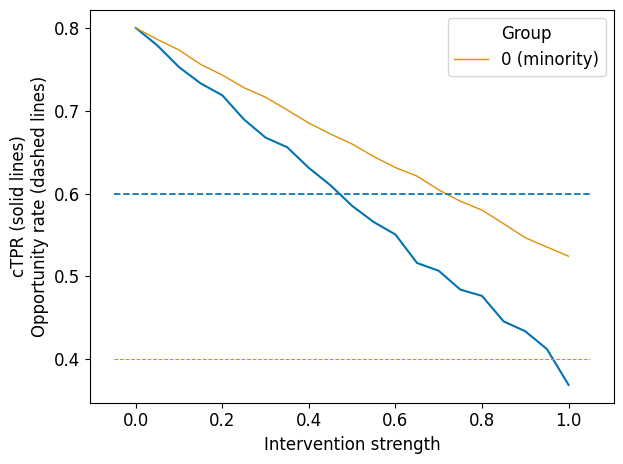

In [98]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['pdf.fonttype'] = 42
ax = sns.lineplot(data=res_EO_pre, x='strength', y='cTPR', hue = 'A', size = 'A', sizes = [1.5, 1],
                 palette = sns.color_palette('colorblind')[0:2])
ax.set_xlabel('Intervention strength')
ax.set_ylabel('cTPR (solid lines)\nOpportunity rate (dashed lines)')
handles, labels = ax.get_legend_handles_labels()
ax.hlines(opportunity_rates, *ax.get_xlim(), color = sns.color_palette('colorblind')[0:2],
         linestyle = '--', linewidth=[1.25, 0.75])
ax.legend(handles=handles[1:], labels=['0 (minority)', '1 (majority)'], title = 'Group')
plt.tight_layout()
plt.show()
ax.get_figure().savefig(os.path.join(FIGPATH, 'intro_figure.pdf'), pad_inches = 0)

## Task 3 plots: Simulating Performance tradeoffs

The goal here is to visualize the tradeoff between performance and accuracy. We start with a perfect predictor of $Y_0$ (not of $Y$) and get the optimal derived predictor over a grid of values for $(\epsilon^+, \epsilon^-)$.

The data generating process used in the other simulations results in a Bayes-optimal predictor with error rate differences around 0.05, so there's not much room to show tradeoffs. Hence we define a new data generating process just for this section.

In [99]:
## Different beta_Y0 than what was used for the previous simulations.

prob_A = 0.3
beta_X = [1, -0.8, 4, 2]
beta_D_pre = [0.2, -1, 1, -1, 1]
beta_Y0 = [-4, 2/5.0, -3/5.0, 4/5.0, -1]
beta_Y1 = [1, -2, 3, -4, 5]

A = 'A'
X = ['X1', 'X2', 'X3', 'X4']
R = 'R'
D = 'D'
Y = 'Y'

data_params_pre = {
    'prob_A': prob_A,
    'beta_X': beta_X,
    'beta_D': beta_D_pre,
    'beta_Y0': beta_Y0,
    'beta_Y1': beta_Y1,
}

### Check that the data-generating process looks reasonable

In [100]:
dat = generate_data_pre(50_000, **data_params_pre)
dat['R'] = (dat.mu0 >= 0.5).astype(float)
check_data_post(dat)

Cross-tabs for sensitive feature A, decision D, potential outcome Y0, and observable outcome Y.
---------------
D      0.0    1.0
A                
0.0  17544  17395
1.0  12369   2692
---------------
Y0     0.0    1.0
A                
0.0  17476  17463
1.0  12026   3035
---------------
Y      0.0    1.0
A                
0.0  12712  22227
1.0  11536   3525
---------------

How often Y = Y0: 0.7284 

Properties of input predictor R

-------------------------
Confusion matrix for Y, R
-------------------------
[[0.31334 0.17162]
 [0.30786 0.20718]] 

------------------------------
Classification report for Y, R
------------------------------
              precision    recall  f1-score   support

       Y = 0       0.50      0.65      0.57     24248
       Y = 1       0.55      0.40      0.46     25752

    accuracy                           0.52     50000
   macro avg       0.53      0.52      0.52     50000
weighted avg       0.53      0.52      0.51     50000
 

----------------------

In [101]:
# Performance for the Bayes-optimal binary predictor of Y0 in A, X
metrics_post_simple([0, 1, 0, 1], dat, outcome='mu0', ci=None)

,metric,value,ci_lower,ci_upper
0,risk,0.238964,None,None
1,risk_change,0.000000,None,None
2,FPR0,0.268874,None,None
3,FPR1,0.041649,None,None
4,gap_FPR,0.227225,None,None
5,FNR0,0.268599,None,None
6,FNR1,0.686165,None,None
7,gap_FNR,-0.417566,None,None
8,pred_change,0.000000,None,None


In [102]:
## Get optimal derived predictor for each combo of unfairness tolerances

epsilons = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1] +\
       [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

res = simulate_performance_tradeoff(100_000, data_params_pre, epsilons, epsilons)
res.to_csv(os.path.join(OUTPATH, 'task3/optimal_predictors_grid.csv'), index = False)

### Generate plot

In [103]:
res_array = res[res.metric == 'risk_change'].pivot(index='epsilon_neg',
                                                   columns='epsilon_pos',
                                                   values='value')
res_array = res_array.reindex(sorted(res_array.columns, reverse = True), axis = 1)

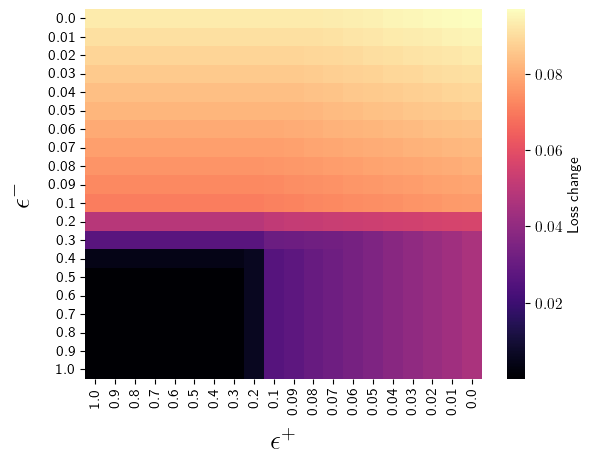

In [ ]:
## Sometimes need to run this twice to get the formatting right
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 11
ax = sns.heatmap(res_array, cmap = 'magma', cbar_kws = {'label': 'Loss change'})
ax.set_xlabel(r'$\epsilon^+$', fontsize = 20, labelpad = 10)
ax.set_ylabel(r'$\epsilon^-$', fontsize = 20, labelpad = 10)
ax.get_figure().savefig(os.path.join(OUTPATH, 'performance_tradeoff.png'),
                        bbox_inches = 'tight', dpi = 600)
plt.show()